## HMC Analysis

In [17]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2
from rich.console import Console
from rich.theme import Theme
console = Console(theme=Theme({"repr.number": "cyan"}))
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
sns.set(context="notebook")
sns.set_palette('bright')
#%matplotlib inline
#plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

In [19]:
print(10)

10


In [20]:
def filter_dict(d, cond, key=None):
    if key is not None:
        val = d[key]
        if isinstance(val, dict):
            return {
                k: v for k, v in val.items() if cond
            }
        raise ValueError('If passing a key, d[key] should be a dict.')
    return {
        k: v for k, v in d.items() if cond
    }

In [21]:
def _look(p, s, conds=None):
    print(f'Looking in {p}...')
    matches = [x for x in Path(p).rglob(f'*{s}*')]
    if conds is not None:
        if isinstance(conds, (list, tuple)):
            for cond in conds:
                matches = [x for x in matches if cond(x)]
        else:
            matches = [x for x in matches if cond(x)]

    return matches

In [6]:
def _get_l2hmc_dirs(paths):
    def _look(p, s, conds=None):
        print(f'Looking in {p}...')
        matches = [x for x in Path(p).rglob(f'*{s}*')]
        if conds is not None:
            if isinstance(conds, (list, tuple)):
                for cond in conds:
                    matches = [x for x in matches if cond(x)]
            else:
                matches = [x for x in matches if cond(x)]
                
        return matches
    
    dirs = []
    conds = (
        lambda x: 'GaugeModel_logs' in (str(x)),
        lambda x: 'HMC_' not in str(x),
        lambda x: Path(x).is_dir(),
    )
    if isinstance(paths, (list, tuple)):
        for path in paths:
            dirs += _look(path, 'L16_b', conds)
            
    else:
        dirs = _look(paths, 'L16_b', conds)
        
            #print(f'Looking in {path}...')
            #dirs += [
            #    x for x in path.rglob('*L16_b*') 
            #    if 'GaugeModel_logs' in str(x)
            #    and 'HMC_' not in str(x)
            #    and x.is_dir()
            #]
            
    
    return dirs

def _get_hmc_dirs(paths):
    dirs = []
    for path in list(paths):
        path = Path(path)
        print(f'Looking in {path}...')
        dirs += [
            x for x in path.rglob('*hmc_logs*') 
            if 'hmc' in str(x).lower()
            and '_b128' in str(x)
            #if 'GaugeModel_logs' in str(x)
            #and 'HMC_' not in str(x)
            and x.is_dir()
        ]
    
    return dirs

In [22]:
import utils.file_io as io
from utils.attr_dict import AttrDict

def load_from_dir(d):
    darr = [x for x in d.iterdir() if x.is_dir()]
    
    for rd in darr:
        dqf = sorted(rd.glob('*dq.z*'))[0]
        qf = sorted(rd.glob('*charges.z*'))[0]
        pf = sorted(rd.rglob('*run_params.z*'))[0]
        
        dq = io.loadz(dqf)
        q = io.loadz(qf)
        rp = io.loadz(pf)
    pass
        

def load_charge_data(dirs, hmc=False):
    q = {}
    dq = {}
    for rd in dirs:
        print(f'Looking in dir: {rd}...')
        if 'inference_hmc' in str(rd):
            print(f'Skipping {str(rd)}...')
            continue
        #contents = os.listdir(d)
        
        #if hmc:
        #    run_dir = Path(os.path.join(d, 'inference_hmc'))
        #else:
        #    run_dir = Path(os.path.join(d, 'inference'))
            
        #if run_dir.is_dir():
        #run_dirs = []
        #for c in contents:
        #    run_dirs += [x for x in Path(os.path.join(d, c)).iterdir() if x.is_dir()]
            
        #run_dirs = [x for x in run_dir.iterdir() if x.is_dir()]
        #for rd in run_dirs:
        print(f'......looking in run_dir: {rd}...')
        dq_file = sorted(rd.rglob('dq.z'))
        q_file = sorted(rd.rglob('charges.z'))
        rp_file = sorted(rd.rglob('run_params.z'))
        num_runs = len(dq_file)
        if num_runs > 0:
            #for dqif, dqsf, qf, rpf in zip(dqi_file, dqs_file, q_file, rp_file):
            for dqf, qf, rpf in zip(dq_file, q_file, rp_file):
                params = io.loadz(rpf)

                if 'xeps' and 'veps' in params.keys():
                    xeps = tf.reduce_mean(params['xeps'])
                    veps = tf.reduce_mean(params['veps'])
                    eps = tf.reduce_mean([xeps, veps])
                    #xeps = np.array([i.numpy() for i in params['xeps']])
                    #veps = np.array([i.numpy() for i in params['veps']])
                    #eps = (np.mean(xeps) + np.mean(veps)) / 2.
                elif 'eps' in params.keys():
                    eps = params['eps']
                    
                #if tf.is_tensor(eps):
                #    eps = eps.numpy()
                eps = tf.reduce_mean(eps).numpy()

                beta = params['beta']
                #eps = params['eps']
                num_steps = params['num_steps']
                print(f'        loading data for (beta, num_steps, eps): ({beta}, {num_steps}, {eps})')
                def _update_dict(z, f):
                    try:
                        z[beta].update({
                            (num_steps, eps): io.loadz(f)
                        })
                    except KeyError:
                        z[beta] = {
                            (num_steps, eps): io.loadz(f)
                        }
                    return z
                q = _update_dict(q, qf)
                dq = _update_dict(dq, dqf)
                
    return AttrDict(q), AttrDict(dq)

## Helper for computing statistics

In [8]:
from utils.data_utils import therm_arr 


def bootstrap_new(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)
    avg = (upper + lower) / 2
    err = np.abs(upper - avg)
    return avg, err


def bootstrap1(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps))
    mb = xb.mean(axis=0)
    mb.sort()
    upper, lower = np.percentile(mb, [2.5, 97.5])
    return np.mean(mb), np.max([upper, lower])
    
    return mb, np.percentile(mb, [2.5, 97.5], axis=1)


def bootstrap(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5])
    
    return yb, max([upper - np.mean(yb), np.mean(yb) - lower])


def dq_stats(dq_dict, reps=1000, therm_frac=0.25):
    stats = {}
    avgs = {}
    errs = {}
    for key, val in dq_dict.items():
        print(120 * '-')
        print(f'key: {key}...')
        for k, v in val.items():
            print(f'.....key, val.shape: {k}, {v.shape}')
            data = therm_arr(v, therm_frac=therm_frac, ret_steps=False)
            print(f'.....key, therm_arr.shape: {k}, {data.shape}')
            avgs_ = []
            errs_ = []
            for chain in data.T:
                avg, err = bootstrap(chain, reps)
                avgs_.append(avg)
                errs_.append(err)
                
            print(f'.....key, avg: {k}, {np.mean(avgs_)} +/- {np.mean(errs_)}')
            try:
                avgs[key].update({'avgs': avgs_, 'errs': errs_})
            except KeyError:
                avgs[key] = {'avgs': avgs_, 'errs': errs_}
            try:
                stats[key].update({
                    k: {
                        'avg': np.mean(avgs_),
                        'avg_std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                })
            except KeyError:
                stats[key] = {
                    k: {
                        'avg': np.mean(avgs_),
                        'std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                }
                
    return stats, avgs, errs

In [9]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def integrated_autocorr5(x, size='cbrt'):
    r"""Estimate the integrated autocorrelation time, :math:`\tau_{int}` of a
    time series.

    This method uses the consistent non-overlapping batch means estimator [1]
    where the number of batches are chosen as functions of the overall run
    length.

    Parameters
    ----------
    x : ndarray, shape=(n_samples, n_dims)
        The time series, with time along axis 0.
    size : {'sqrt', 'cbrt'}
        The batch size. The default value is "sqroot", which uses the square
        root of the sample size. "cuberoot" will cause the function to use the
        cube root of the sample size. A numeric value may be provided if
        neither "sqrt" nor "cbrt" is satisfactory.

    References
    ----------
    .. [1] Flegal, J. M., Haran, M. and Jones, G. L. (2008) Markov chain Monte
       Carlo: Can we trust the third significant figure? Statistical Science,
       23, 250-260.

    Returns
    -------
    tau_int : ndarray, shape=(n_dims,)
      The estimated integrated autocorrelation time of each dimension in
      ``x``, considered independently.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)

    if size == 'sqrt':
        batch_size = int(np.sqrt(x.shape[0]))
    elif size == 'cbrt':
        batch_size = int(x.shape[0]**0.5)
    elif np.isscalar(size):
        batch_size = size
    else:
        raise NotImplementedError('unrecoginized argument, size=%s' % size)

    bigvar = np.var(x, axis=0, ddof=1)
    # leave off the extra bit at the end that's not a clean multiple
    x = x[:batch_size*(len(x)//batch_size)]
    bigmean = np.mean(x, axis=0)

    sigma2_bm = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        # reshape into the batches, and then compute the batch-means
        bm = x[:, j].reshape(-1, batch_size).mean(axis=1)
        sigma2_bm[j] = (batch_size / (len(bm)-1)) * np.sum((bm-bigmean[j])**2)

    return sigma2_bm / bigvar

## Calculate $\tau_{\mathrm{int}}$ using ML

In [10]:
import autograd
import celerite
from celerite import terms
from scipy.optimize import minimize


def autocorr_ml(y, thin=1, c=5.0):
    # Compute the initial estimate of tau using the standard method
    init = autocorr_new(y, c=c)
    z = y[:, ::thin]
    N = z.shape[1]

    # Build the GP model
    tau = max(1.0, init / thin)
    kernel = terms.RealTerm(
        np.log(0.9 * np.var(z)), -np.log(tau), bounds=[(-5.0, 5.0), (-np.log(N), 0.0)]
    )
    kernel += terms.RealTerm(
        np.log(0.1 * np.var(z)),
        -np.log(0.5 * tau),
        bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
    )
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    # Define the objective
    def nll(p):
        # Update the GP model
        gp.set_parameter_vector(p)

        # Loop over the chains and compute likelihoods
        v, g = zip(*(gp.grad_log_likelihood(z0, quiet=True) for z0 in z))

        # Combine the datasets
        return -np.sum(v), -np.sum(g, axis=0)

    # Optimize the model
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    gp.set_parameter_vector(soln.x)

    # Compute the maximum likelihood tau
    a, c = kernel.coefficients[:2]
    tau = thin * 2 * np.sum(a / c) / np.sum(a)
    return tau




findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


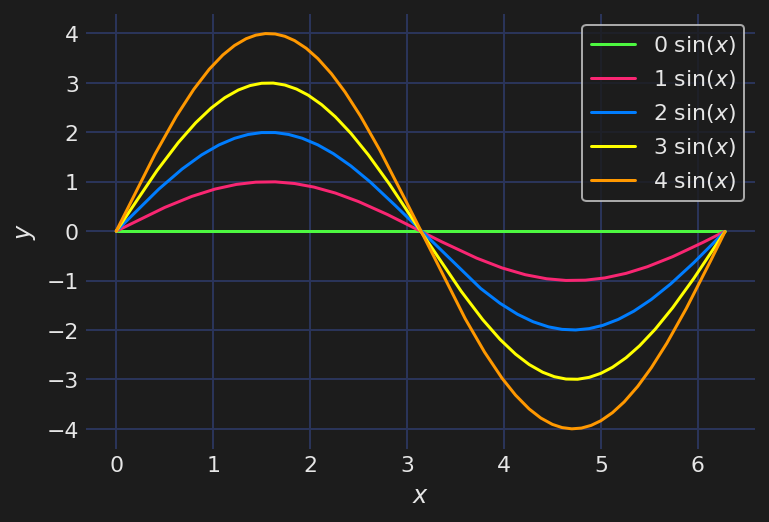

In [11]:
try:
    plt.style.use('molokai')
except:
    pass

fig, ax = plt.subplots()
x = np.arange(0, 2*np.pi, 0.02)
for i in range(5):
    _ = ax.plot(x, i * np.sin(x), label=f'{i} ' + r"$\sin(x)$")
    
_ = ax.legend(loc='best')
fig.set_facecolor('#1c1c1c')
_ = ax.set_xlabel(r"$x$")
_ = ax.set_ylabel(r"$y$")

#import tikzplotlib
#tikzplotlib.save("/Users/saforem2/Downloads/sin_tikz.tex")
# or
#tikzplotlib.save("mytikz.tex", flavor="context")a

Specify HMC dirs to look in for data

In [25]:
from config import LOGS_DIR
import glob
from pathlib import Path

hmc_dirs = []
hmc_dir = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')
if os.path.isdir(hmc_dir):
    hmc_dir = Path(hmc_dir)
    hmc_dirs += [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]
    
    
hmc_dir = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')
if os.path.isdir(hmc_dir):
    hmc_dir = Path(hmc_dir)
    hmc_dirs += [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]

# From local machine:
hmc_dir = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc_2020_12_20/')
if os.path.isdir(hmc_dir):
    hmc_dir = Path(hmc_dir)
    hmc_dirs += [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]

# From `thetaGPU`:
#hmc_dir = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')

# From local machine:
#hmc_dir = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc_2020_12_20/')
#hmc_dir = Path(hmc_dir)

#hmc_dirs = [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]

# hmc_dir1 = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')
# hmc_dir1 = Path(hmc_dir1)

# hmc_dirs += [x for x in hmc_dir1.rglob('*HMC_L16*') if x.is_dir()]

In [26]:
len(hmc_dirs)

298

 Specify L2HMC dirs (from JLSE and thetaGPU) containing data

In [27]:
from pathlib import Path

l2hmc_dirs = []

# From thetaGPU:
base_dir_thetaGPU = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training/')
if os.path.isdir(base_dir_thetaGPU):
    l2hmc_dirs += _get_l2hmc_dirs(base_dir_thetaGPU)
console.print(len(l2hmc_dirs))
    
base_dir_thetaGPU = os.path.abspath('/Users/saforem2/thetaGPU/training/')
if os.path.isdir(base_dir_thetaGPU):
    l2hmc_dirs += _get_l2hmc_dirs(base_dir_thetaGPU)
console.print(len(l2hmc_dirs))
    
# From local machine:
base_dir_local = os.path.abspath('/Users/saforem2/thetaGPU/training/')
if os.path.isdir(base_dir_local):
    l2hmc_dirs += _get_l2hmc_dirs(base_dir_local)
    
l2hmc_dirs = sorted(l2hmc_dirs)
console.print(len(l2hmc_dirs))
# ====
# Older training runs, no longer needed with new (better) results as of (12/05/2020)
# base_dir1 = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training_2020_11')
# l2hmc_dirs += _get_l2hmc_dirs(base_dir1)

Looking in /Users/saforem2/thetaGPU/training...


Looking in /Users/saforem2/thetaGPU/training...


In [ ]:
q_l2hmc, dqi_l2hmc = load_charge_data(l2hmc_dirs)
q_l2hmc.keys()

Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj...
        loading data for (beta, num_steps, eps): (5.0, 10, 0.19424471259117126)
        loading data for (beta, num_steps, eps): (5.0, 10, 0.19424183666706085)
        loading data for (beta, num_steps, eps): (5.0, 10, 0.1957567036151886)
        loading data for (beta, num_steps, eps): (5.0, 10, 0.19395266473293304)
        loading data for (beta, num_steps, eps): (5.0, 10, 0.1915840059518814)
        loading data for (beta, num_steps, eps): (5.0, 10, 0.19424471259117126)
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b

In [ ]:
q_hmc, dqi_hmc = load_charge_data(hmc_dirs, hmc=True)
q_hmc.keys()

In [17]:
q_hmc = {}
dqi_hmc = {}

beta_conds = [
    lambda beta: beta < 4.0,
    lambda beta: beta == 5.5,
]

for hdir in hmc_dirs:
    print(f'Looking in dir: {hdir}')
    dqif = sorted(hdir.rglob('dq.z'))
    qf = sorted(hdir.rglob('charges.z'))
    pf = sorted(hdir.rglob('run_params.z'))
    if len(dqif) > 0:
        for dqif_, qf_, pf_ in zip(dqif, qf, pf):
            #print(f'......looking in run_dir: {rd}...')
            
            params = io.loadz(pf[0])
            beta = params['beta']
            if 'xeps' and 'veps' in params.keys():
                xeps = np.array([i.numpy() for i in params['xeps']])
                veps = np.array([i.numpy() for i in params['veps']])
                eps = (np.mean(xeps) + np.mean(veps)) / 2.
            elif 'eps' in params.keys():
                eps = params['eps']
                
            #eps = params['eps']
            num_steps = params['num_steps']
            
            for cond in beta_conds:
                if cond(beta):
                    continue
                
            def _update_dict(d, f):
                try:
                    d[beta].update({
                        (num_steps, eps): io.loadz(f)
                    })
                except KeyError:
                    d[beta] = {
                        (num_steps, eps): io.loadz(f)
                    }

                return d

            q_hmc = _update_dict(q_hmc, qf_)
            dqi_hmc = _update_dict(dqi_hmc, dqif_)

q_hmc = AttrDict(q_hmc)
dqi_hmc = AttrDict(dqi_hmc)

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf20_eps025-2020-12-20-0745
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps005-2020-12-20-0759
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf15_eps005-2020-12-20-0743
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps02-2020-12-20-0742
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf15_eps015-2020-12-20-0817
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf20_eps02-2020-12-20-0745
Looking in dir: /Users/saforem2/thetaGPU/inferen

In [18]:
q_hmc.keys()

dict_keys([7.0, 6.0, 5.0])

In [19]:
from copy import deepcopy

q_hmc_copy = deepcopy(q_hmc)
q_l2hmc_copy = deepcopy(q_l2hmc)

In [20]:
q_hmc = {k: v for k, v in q_hmc.items() if k > 4.5 and k != 5.5}
q_hmc.keys()

dict_keys([7.0, 6.0, 5.0])

In [21]:
q_l2hmc = {k: v for k, v in q_l2hmc.items() if k > 4.5}
q_l2hmc.keys()

dict_keys([5.0, 6.0, 7.0])

In [22]:
q_l2hmc[5.0].keys()

dict_keys([(10, 0.19424471), (10, 0.19424184), (10, 0.1957567), (10, 0.19395266), (10, 0.191584), (10, 0.18413678), (10, 0.15467422), (10, 0.19014968), (10, 0.1970841), (10, 0.19755399), (10, 0.19559464), (10, 0.19497973), (10, 0.18409148), (10, 0.19657207), (10, 0.20836465), (10, 0.20908755), (10, 0.20942947), (10, 0.31429398), (10, 0.11966534), (10, 0.24481377), (10, 0.05), (10, 0.24578927)])

In [61]:
q_hmc[5.0].keys()

dict_keys([(15, 0.05000000447034836), (20, 0.20000000298023224), (25, 0.05000000074505806), (25, 0.25), (15, 0.15000000596046448), (15, 0.02500000223517418), (20, 0.10000000149011612), (10, 0.10000000149011612), (20, 0.15000002086162567), (20, 0.25), (10, 0.05000000074505806), (10, 0.20000000298023224), (25, 0.02500000037252903), (25, 0.15000000596046448), (20, 0.02500000037252903), (15, 0.25), (10, 0.15000000596046448), (20, 0.05000000074505806), (10, 0.25)])

In [28]:

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf


# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]


def calc_autocorr_old(y, num_pts=20, nstart=100):
    N = np.exp(np.linspace(np.log(nstart), np.log(y.shape[1]), num_pts)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        #new[i] = autocorr_new(y[:, :n])
        new[i] = autocorr_ml(y[:, :n])
        
    return N, new

def calc_autocorr(y, num_pts=20, nstart=100, autocorr_fn=autocorr_new):
    N = np.exp(np.linspace(np.log(nstart), np.log(y.shape[1]), num_pts)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr_fn(y[:, :n])
        #new[i] = autocorr_new(y[:, :n])
        #new[i] = autocorr_ml(y[:, :n])
        
    return N, new

def calc_autocorr1(y, num_pts=20, nstart=100):
    N = np.exp(np.linspace(np.log(nstart), np.log(y.shape[0]), num_pts)).astype(int)
    new = np.empty((len(N), y.shape[1]))
    #new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = integrated_autocorr5(y[:n, :])
        
    return N, new

In [29]:
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.data_utils import therm_arr
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

In [64]:
# n_l2hmc = []
# tint_l2hmc = {}
# tint_l2hmc1 = {}
# tint_l2hmc2 = {}
# for key, val in q_l2hmc[5.0].items():
#     qarr, _ = therm_arr(val) # qarr.shape = [draws, chains]
#     qarr = qarr.T            # qarr.T.shape = [chains, draws]
#     chains, draws = qarr.shape
    
#     x1 = qarr[:chains//2 - 1]
#     x2 = qarr[chains//2:]
    
#     n1, tint1 = calc_autocorr(x1)
#     n2, tint2 = calc_autocorr(x2)
    
#     n, tint = calc_autocorr(qarr)
#     #n_l2hmc[key] = n
#     tint_l2hmc[key] = {'N': n, 'tint': tint}
#     tint_l2hmc1[key] = {'N': n1, 'tint': tint1}
#     tint_l2hmc2[key] = {'N': n2, 'tint': tint2}

# key = list(q_l2hmc[5.0].keys())[0]
# val = q_l2hmc[5.0][key]
# val.shape

# q = qarr[:, :100]

# n1, tint1 = calc_autocorr(qarr)
# n2, tint2 = calc_autocorr(q)

In [65]:
import autograd

In [68]:
import time

def calc_tau_int_old(qdata, therm_frac=0.2, min_samples=100, min_chains=1):
    tau_int = {key: {} for key, _ in qdata.items()}
    for key, val in qdata.items():
        print(f'* key: {key}')
        # tau_int[key] = {}
        for k, v in val.items():
            qarr, _ = therm_arr(v, therm_frac=therm_frac)  # qarr.shape = [draws, chains]
            qarr = qarr.T                            # qarr.T.shape = [chains, draws]

            chains, draws = qarr.shape
            chains, draws = qarr.shape
            if chains < min_chains:
                continue
            
            if draws < min_samples:
                continue
                
            t0 = time.time()
            n, tint = calc_autocorr(qarr, num_pts=5, nstart=min_samples)
            #N = 
            # N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 20)).astype(int)
            # new = np.empty(len(N))
            # for i, n in enumerate(N):
            #     new[i] = autocorr_new(y[:, :n])
            #     #new[i] = autocorr_ml(y[:, :n])
            t1 = time.time()
            print(f'  - traj_len: {k[0] * k[1]:.3g}, chains: {chains}, draws: {draws},'
                  f' n: {n[-1]}, tau_int: {tint[-1]:.3g}   (took: {t1 - t0:.3g}s)')
            # print(f'  - k, (chains, draws): {k}, ({chains}, {draws})')
            # print(f'      ~ n, tint: {n[-1]}, {tint[-1]:.3g}    (took: {t1 - t0:.3g}s)')
            
            #if np.isfinite(np.sum(np.isfinite(tint))) and np.isfinite(tint[-1]):
            if np.isfinite(tint[-1]):
                tau_int[key][k] = {
                    'N': n,
                    'tau_int': tint
                }
#                 tint_arr = []
#                 for idx, chain in enumerate(qarr[:3]):
#                     t0 = time.time()
#                     n_, tint_ = calc_autocorr(chain[:, None])
#                     tint_arr.append(tint_)
#                     t1 = time.time()
#                     print(f'      {idx} took ~ {t1 - t0:.4g}s')
#                     print(f'      {idx} n, tint: {n_}, {tint_}')
                
                
#                 print(f'  - tint_arr.mean: {np.mean(tint_arr)} +/- {np.std(tint_arr)}')



            # x1 = qarr[:chains//2-1].flatten()
            # x2 = qarr[chains//2:].flatten()

            # n0, tint0 = calc_autocorr(qarr)
            # n1, tint1 = calc_autocorr(x1[:, None])
            # n2, tint2 = calc_autocorr(x2[:, None])

            # n, tint = calc_autocorr(qarr)
            # tau_int[key][k] = {
            #     'N': n,
            #     'tau_int': tint,
            # }

    return tau_int

In [32]:
import time

def calc_tau_int(qdata, therm_frac=0.2, min_samples=100, min_chains=1, autocorr_fn=autocorr_new, num_pts=10):
    tau_int = {key: {} for key, _ in qdata.items()}
    for key, val in qdata.items():
        print(f'* key: {key}')
        # tau_int[key] = {}
        for k, v in val.items():
            # qarr.shape: [draws, chains]
            qarr, _ = therm_arr(v, therm_frac=therm_frac)
            draws, chains = qarr.shape
            # qarr.T.shape: [chains, draws]
            # NOTE: if autocorr_fn == autocorr_new,
            if chains < min_chains:
                continue
            
            if draws < min_samples:
                continue
            
            if autocorr_fn == autocorr_new:
                qarr = qarr.T                                  # qarr.T.shape = [chains, draws] 
                chains, draws = qarr.shape
                t0 = time.time()
                n, tint = calc_autocorr(qarr, num_pts=5, nstart=min_samples,
                                        autocorr_fn=autocorr_fn)
                t1 = time.time()
            elif autocorr_fn == integrated_autocorr5:
                t0 = time.time()
                n, tint = calc_autocorr1(qarr, num_pts=num_pts, nstart=min_samples)
                                         #autocorr_fn=autocorr_fn)
                t1 = time.time()
                
            #t0 = time.time()
            #n, tint = calc_autocorr(qarr, num_pts=5, nstart=min_samples,
            #                        autocorr_fn=autocorr_fn)
            #N = 
            # N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 20)).astype(int)
            # new = np.empty(len(N))
            # for i, n in enumerate(N):
            #     new[i] = autocorr_new(y[:, :n])
            #     #new[i] = autocorr_ml(y[:, :n])
            #t1 = time.time()
            print(f'  - traj_len: {k[0] * k[1]:.3g}, chains: {chains}, draws: {draws},'
                  f' n[0]: {n[0]}, n.shape: {n.shape}, tau_int: {tint[-1].mean():.3g} +/- {tint[-1].std():.3g}'
                  f'   (took: {t1 - t0:.3g}s)')
            # print(f'  - k, (chains, draws): {k}, ({chains}, {draws})')
            # print(f'      ~ n, tint: {n[-1]}, {tint[-1]:.3g}    (took: {t1 - t0:.3g}s)')
            
            #if np.isfinite(np.sum(np.isfinite(tint))) and np.isfinite(tint[-1]):
            if np.isfinite(tint[-1].mean()):
                tau_int[key][k] = {
                    'lf': k[0],
                    'eps': k[1],
                    'traj_len': k[0] * k[1],
                    'N': n,
                    'tau_int': tint
                }
#                 tint_arr = []
#                 for idx, chain in enumerate(qarr[:3]):
#                     t0 = time.time()
#                     n_, tint_ = calc_autocorr(chain[:, None])
#                     tint_arr.append(tint_)
#                     t1 = time.time()
#                     print(f'      {idx} took ~ {t1 - t0:.4g}s')
#                     print(f'      {idx} n, tint: {n_}, {tint_}')
                
                
#                 print(f'  - tint_arr.mean: {np.mean(tint_arr)} +/- {np.std(tint_arr)}')



            # x1 = qarr[:chains//2-1].flatten()
            # x2 = qarr[chains//2:].flatten()

            # n0, tint0 = calc_autocorr(qarr)
            # n1, tint1 = calc_autocorr(x1[:, None])
            # n2, tint2 = calc_autocorr(x2[:, None])

            # n, tint = calc_autocorr(qarr)
            # tau_int[key][k] = {
            #     'N': n,
            #     'tau_int': tint,
            # }

    return tau_int

In [33]:
#tint_l2hmc = calc_tau_int(q_l2hmc, therm_frac=0.2, min_samples=5e3, min_chains=512)
tint_l2hmc = calc_tau_int(q_l2hmc, therm_frac=0.2, min_samples=5e3, min_chains=512, autocorr_fn=integrated_autocorr5)

* key: 5.0
  - traj_len: 1.94, chains: 512, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 29.7 +/- 3.24   (took: 0.454s)
  - traj_len: 1.96, chains: 512, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 32 +/- 3.35   (took: 0.388s)
  - traj_len: 1.94, chains: 512, draws: 20000, n[0]: 5000, n.shape: (10,), tau_int: 34.8 +/- 3.17   (took: 0.753s)
  - traj_len: 1.92, chains: 512, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 39.6 +/- 2.89   (took: 2.35s)
  - traj_len: 1.96, chains: 512, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 38.1 +/- 3.8   (took: 0.445s)
  - traj_len: 1.95, chains: 512, draws: 20000, n[0]: 5000, n.shape: (10,), tau_int: 43.2 +/- 3.86   (took: 0.741s)
  - traj_len: 2.09, chains: 2048, draws: 20000, n[0]: 5000, n.shape: (10,), tau_int: 37.3 +/- 3.57   (took: 11.2s)
  - traj_len: 1.2, chains: 2048, draws: 20000, n[0]: 5000, n.shape: (10,), tau_int: 113 +/- 4.16   (took: 14.1s)
  - traj_len: 2.46, chains: 2048, draws: 20000, n[0]: 5000, n.shape: (10,), t

/Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


  - traj_len: 1.6, chains: 1024, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 86.1 +/- 5.9   (took: 5.65s)
  - traj_len: 1.81, chains: 1024, draws: 20000, n[0]: 5000, n.shape: (10,), tau_int: 58 +/- 4.62   (took: 2.69s)
  - traj_len: 1.82, chains: 512, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 52.2 +/- 4.17   (took: 0.799s)
  - traj_len: 1.54, chains: 512, draws: 8000, n[0]: 5000, n.shape: (10,), tau_int: 86.1 +/- 5.05   (took: 0.774s)


In [35]:
tint_l2hmc_ = {beta: {} for beta in tint_l2hmc.keys()}
for key, val in tint_l2hmc.items():
    for k, v in val.items():
        if key == 5.0 and v['tau_int'][-1].mean() > 100:
            continue
        if key == 6.0 and v['tau_int'][-1].mean() > 60:
            continue
        if key == 7.0 and v['tau_int'][-1].mean() > 70:
            continue
        else:
            tint = v['tau_int']
            console.print(f'{key}, {k}:')
            console.print(tint)
            tint_l2hmc_[key][k] = v

In [36]:
#tint_l2hmc_ = {k: {} for k, _ in tint_l2hmc.items()}
#for key, val in tint_l2hmc.items():
#    for k, v in val.items():
#        if np.isfinite(np.sum(v['tau_int'])):
#            console.print(f'{key}: ({k[0]}, {k[1]}): {v["tau_int"]}')
#            tint_l2hmc_[key][k] = v
#
#tint_l2hmc_ = {k: {} for k, _ in tint_l2hmc.items()}
#for key, val in tint_l2hmc.items():
#    for k, v in val.items():
#        if np.isfinite(np.sum(v['tau_int'])):
#            console.print(f'{key}: ({k[0]}, {k[1]}): {v["tau_int"]}')
#            tint_l2hmc_[key][k] = v

In [38]:
#tint_hmc = calc_tau_int(q_hmc, therm_frac=0.2)#, min_samples=1e3, min_chains=128)
tint_hmc = calc_tau_int(q_hmc, therm_frac=0.2, min_samples=5e3, min_chains=8, autocorr_fn=integrated_autocorr5)

* key: 7.0
  - traj_len: 5, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: nan +/- nan   (took: 0.0896s)


/Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide


  - traj_len: 0.625, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 313 +/- 1.5   (took: 0.122s)
  - traj_len: 0.5, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 314 +/- 1.89   (took: 0.237s)
  - traj_len: 3.75, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: nan +/- nan   (took: 0.139s)
  - traj_len: 2, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 309 +/- 3.26   (took: 0.176s)
  - traj_len: 2, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 315 +/- 2.24   (took: 0.186s)
  - traj_len: 0.375, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 314 +/- 1.97   (took: 0.191s)
  - traj_len: 0.25, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 314 +/- 1.41   (took: 0.154s)
  - traj_len: 0.75, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 312 +/- 1.65   (took: 0.124s)
  - traj_len: 3.75, chains: 8, draws: 100000, n[0]: 5000, n.shape: (10,), tau_int: 309 +/- 2.9   (took:

In [39]:
tint_hmc_ = {beta: {} for beta in tint_hmc.keys()}
for key, val in tint_hmc.items():
    for k, v in val.items():
        if np.isnan(v['tau_int'][-1].mean()):
            continue
        else:
            tint = v['tau_int']
            console.print(f'{key}, {k}:')
            console.print(tint)
            tint_hmc_[key][k] = v

In [59]:
console.print(tint_hmc)

In [40]:
from matplotlib import cm 

beta_str = {
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}

tl_hmc = []
tl_l2hmc = []
traj_lengths_hmc = {}
traj_lengths_l2hmc = {}
for key, val in tint_hmc.items():
    traj_lengths_hmc[key] = {
        k: k[0] * k[1] for k in val.keys()
    }
    traj_lengths_hmc[key] = dict(sorted(traj_lengths_hmc.items()))
    tl_hmc = [k[0] * k[1] for k in val.keys()]
    
for key, val in tint_l2hmc.items():
    traj_lengths_l2hmc[key] = {
        k: k[0] * k[1] for k in val.keys()
    }
    traj_lengths_l2hmc[key] = dict(sorted(traj_lengths_l2hmc.items()))
    tl_l2hmc = [k[0] * k[1] for k in val.keys()]
    
console.print(traj_lengths_hmc)
console.print(traj_lengths_l2hmc)
tl_hmc = np.unique(tl_hmc)
tl_l2hmc = np.unique(tl_l2hmc)

In [41]:
traj_lengths_hmc =  dict(sorted(traj_lengths_hmc.items()))

In [42]:
console.print(traj_lengths_hmc)

In [39]:
console.print(dict(sorted(tl_hmc.items())))

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [41]:
console.print(tint_hmc[5.0])

In [74]:
hdata = {}
for key, val in tint_hmc_.items():
    # k = (num_leapfrogs, step_size)
    #vsort = dict(sorted(val.items()))
    vsort = dict(sorted(val.items(), key=lambda k: k[0][0] * k[0][1]))
    # NOTE: Multiply v by
    hdata[key] = {
        k[0] * k[1]: {
            'lf': k[0],
            'eps': k[1],
            'traj_len': k[0] * k[1],
            'N': v['N'],
            'tau_int': v['tau_int'],
            'tau_int x N_lf': k[0] * v['tau_int'],
        } for k, v in vsort.items()
    }
    # k[0] * v for k, v in vsort.items()}
    
ldata = {}
for key, val in tint_l2hmc_.items():
    vsort = dict(sorted(val.items(), key=lambda k: k[0][0] * k[0][1]))
    ldata[key] = {
        k[0] * k[1]: {
            'lf': k[0],
            'eps': k[1],
            'traj_len': k[0] * k[1],
            'N': v['N'],
            'tau_int': v['tau_int'],
            'tau_int x N_lf': k[0] * v['tau_int'],
        } for k, v in vsort.items()
    }
    #ldata[key] = {k[0] * k[1]: v for k, v in vsort.items()}
    
#hdata = dict(sorted(hdata, key=lambda d: d[0]))
hdata = dict(sorted(hdata.items()))
ldata = dict(sorted(ldata.items()))
#console.print(ldata[7.0])
#io.print_dict(hdata)
#io.print_dict(ldata)

In [75]:
ldata[5.0].keys()

dict_keys([1.915840059518814, 1.9395266473293304, 1.9424183666706085, 1.94979727268219, 1.9559463858604431, 1.957567036151886, 2.090875506401062, 2.457892745733261])

In [45]:
for key, val in ldata.items():
    for k, v in val.items():
        m = np.max(v['tau_int'])
        if m > 10:
            print(f"max(ldata[{key}][{k:.2g}]['tau_int']) = {m}")

max(ldata[5.0][1.9]['tau_int']) = 52.19473422890141
max(ldata[5.0][1.9]['tau_int']) = 49.07876263992058
max(ldata[5.0][1.9]['tau_int']) = 40.703333665323555
max(ldata[5.0][1.9]['tau_int']) = 54.272411256225325
max(ldata[5.0][2]['tau_int']) = 52.47367607180181
max(ldata[5.0][2]['tau_int']) = 42.39881268608297
max(ldata[5.0][2.1]['tau_int']) = 51.05986063549095
max(ldata[5.0][2.5]['tau_int']) = 49.896858062786485
max(ldata[6.0][1.8]['tau_int']) = 60.75970110420098
max(ldata[6.0][1.8]['tau_int']) = 51.656238879748834
max(ldata[6.0][1.8]['tau_int']) = 64.44793528287354
max(ldata[6.0][1.9]['tau_int']) = 64.42235378154135
max(ldata[7.0][1.8]['tau_int']) = 74.28770266688348
max(ldata[7.0][1.8]['tau_int']) = 62.773941869196534


In [46]:
timestamp = io.get_timestamp()
outdir = os.path.abspath(f'/Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data-{timestamp}')

io.check_else_make_dir(outdir)

houtfile = os.path.join(outdir, 'qdata.z')
io.savez(hdata, houtfile, name='qdata')

loutfile = os.path.join(outdir, 'ldata.z')
io.savez(ldata, loutfile, name='ldata')

In [47]:
houtfile = os.path.join(outdir, 'q_hmc.z')
io.savez(q_hmc, houtfile, name='q_hmc')

loutfile = os.path.join(outdir, 'q_l2hmc.z')
io.savez(q_l2hmc, loutfile, name='q_l2hmc')

In [76]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

legdict = {
    0.25: r"$0.25$",
    1.5: r"$1.5$",
    1.54: r"$1.54$",
    1.8: r"$1.8$",
    1.81: r"$1.81$",
    1.82: r"$1.82$",
    2.09: r"$2.09",
    1.84: r"$1.84$",
    3: r"$3.00$",
    4: r"$4.00$",
    5: r"$5.00$",
    6.25: r"$6.25$",
}
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['x', '', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
labels = {}
label_idxs = {}
label_colors = {}

def plot_autocorrs_old(beta, l2hmc_data, hmc_data, out_dir=None, ax=None, labels=True, cmap='Blues'):
    if ax is None:
        _, ax = plt.subplots()
        
    num_items = len(list(hmc_data.keys()))
    cmap = plt.get_cmap(cmap, num_items + 5)
    tlens = list(hmc_data.keys())
    colormaps = {}
    for idx, tl in enumerate(tlens):
        colormaps[tl] = cmap(idx + 5)
        
        
    midpt = num_items // 2
    good_idxs = [0, num_items - 1, (num_items - 1) // 2]
    hmc_data = dict(sorted(hmc_data.items()))
    for idx, (key, val) in enumerate(hmc_data.items()):
        if not np.sum(np.isfinite(val['tau_int x N_lf'])) or max(val['N']) < 1e3 or np.sum(val['tau_int x N_lf']) < 100:
            continue
            
        if beta == 7. and idx in [0, midpt, num_items - 1]:
            label = f'HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon$ = " 
            label += f'${{{key:.2g}}}$'
        else:
            label = None
            
        _ = ax.errorbar(val['N'], npval['tau_int x N_lf'], marker='.', ls='', lw=0.8, color=cmap(idx+5), alpha=0.8, label=label)
        #_ = ax.loglog(val['N'], val['tau_int x N_lf'], marker='.', ls='', lw=0.8, color=cmap(idx+5), alpha=0.8, label=label)
        
    made_label = False
    num_labels = 0
    l2hmc_data = dict(sorted(l2hmc_data.items()))
    for jdx, (key, val) in enumerate(l2hmc_data.items()):
        #if max(val['N']) < 1e3 or not np.isfinite(val['tau_int x N_lf'][-1]) or max(val['tau_int x N_lf']) > 500:
        #if not np.sum(np.isfinite(val['tau_int x N_lf'])):
        if not np.sum(np.isfinite(val['tau_int x N_lf'])) or max(val['N']) < 1e4 or np.sum(val['tau_int x N_lf']) < 100:
            continue
            
        #@if idx in good_idxs:
        if beta == 7.:
            label = f'L2HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon \simeq $" 
            label += f'${{{key:.2g}}}$'
            made_label = True
            num_labels += 1
            # try:
            #     label += legdict[np.round(key, 1)]
            # except KeyError:
                
        else:
            label = None
            made_label = False
            
        if num_labels == 1:
            _ = ax.loglog(val['N'], val['tau_int x N_lf'], marker='*', fillstyle='none', ls='', color='k', lw=0.8, label=label) # , label=f'L2HMC: {str(key)}')
        else:
            _ = ax.loglog(val['N'], val['tau_int x N_lf'], marker='*', fillstyle='none', ls='', color='k', lw=0.8) # , label=f'L2HMC: {str(key)}')

    _ = ax.set_title(r"$\beta = $" + beta_str[beta])
    
    if beta == 7.:
        _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5)
        #_ = ax.legend(loc='best', markerscale=1.5)
        
    #if beta == 7.:
    #    _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.04), markerscale=1.5)
        
    if out_dir is not None:
        outfile = os.path.join(out_dir, f'tau_int_x_N_lf_chains_beta{beta}'.replace('.', '') + '.png')
        print(f'Saving figure to: {outfile}')
        plt.savefig(outfile, dpi=400, bbox_inches='tight')
        plt.savefig(outfile.replace('.png', '.pdf'), dpi=400, bbox_inches='tight')
        
    return num_items, midpt

In [109]:
def plot_autocorrs(beta, l2hmc_data, hmc_data, out_dir=None, ax=None, labels=True, cmap='Blues'):
    if ax is None:
        _, ax = plt.subplots()
        
    num_items = len(list(hmc_data.keys()))
    cmap = plt.get_cmap(cmap, num_items + 5)
    tlens = list(hmc_data.keys())
    colormaps = {}
    for idx, tl in enumerate(tlens):
        colormaps[tl] = cmap(idx + 5)
        
        
    midpt = num_items // 2
    good_idxs = [0, num_items - 1, (num_items - 1) // 2]
    hmc_data = dict(sorted(hmc_data.items()))
    havgs = {}
    herrs = {}
    for idx, (key, val) in enumerate(hmc_data.items()):
        N = val['N']
        y = val['lf'] * val['tau_int']
        traj_len = val['traj_len']
        yavg = y.mean(axis=1)
        yerr = y.std(axis=1) / yavg
        
        for idx, n in enumerate(N):
            try:
                havgs[n].append(yavg[idx].mean())
                herrs[n].append(yerr[idx].mean())
            except KeyError:
                havgs[n] = [yavg[idx].mean()]
                herrs[n] = [yerr[idx].mean()]
            
        #yavg = val['lf'] * y
        #yerr = y.std(axis=1)
        
        #if not np.sum(np.isfinite(y)) or max(N) < 1e3 or np.sum(y) < 100:
        #    continue
            
        if beta == 7. and idx in [0, midpt, num_items - 1]:
            label = f'HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon$ = " 
            label += f'${{{key:.2g}}}$'
        else:
            label = None
            
        _ = ax.errorbar(N, yavg, yerr, marker='.', ls='',
                        lw=0.8, color=colormaps[traj_len], alpha=0.7, label=label)
        #_ = ax.loglog(N, yavg, marker='.', ls='', lw=0.8, color=cmap(idx+5), alpha=0.6, label=label)
        
    #N_arr = list(havgs.keys())
    
    #havgs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in havgs.items()}
    #herrs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in herrs.items()}
    #for key in havgs_.keys():
    #    havg = havgs_[key]
    #    herr = herrs_[key]
    #    _ = ax.errorbar(key, havg, herr, marker='s', ls='', lw=0.8, color=colormaps[traj_len], alpha=1.0, label=label + '(avg)')
    
    #_ = ax.errorbar(N, yavg, yerr, marker='.', ls='',
    #                lw=0.8, color=colormaps[traj_len], alpha=0.7, label=label)
        
        
    made_label = False
    num_labels = 0
    l2hmc_data = dict(sorted(l2hmc_data.items()))
    lavgs = {}
    lerrs = {}
    for jdx, (key, val) in enumerate(l2hmc_data.items()):
        N = val['N']
        y = val['lf'] * val['tau_int']
        yavg = y.mean(axis=1)
        yerr = y.std(axis=1) / yavg
        for idx, n in enumerate(N):
            try:
                lavgs[n].append(yavg[idx].mean())
                lerrs[n].append(yerr[idx].mean())
            except KeyError:
                lavgs[n] = [yavg[idx].mean()]
                lerrs[n] = [yerr[idx].mean()]
            
        #try:
        #    lavgs[N].append(yavg.mean(axis=1).mean())
        #    lerrs[N].append(yerr.mean(axis=1).mean())
        #except KeyError:
        #    lavgs[N] = {
        #        [yavg]
        #    }
        #    lerrs[N] = {
        #        [yerr]
        #    }
        
        #if max(val['N']) < 1e3 or not np.isfinite(val['tau_int x N_lf'][-1]) or max(val['tau_int x N_lf']) > 500:
        #if not np.sum(np.isfinite(val['tau_int x N_lf'])):
        
        #if not np.sum(np.isfinite(y)) or max(N) < 1e4 or np.sum(y) < 100:
        #    continue
            
        #@if idx in good_idxs:
        if beta == 7.:
            label = f'L2HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon \simeq $" 
            label += f'${{{key:.2g}}}$'
            made_label = True
            num_labels += 1
            # try:
            #     label += legdict[np.round(key, 1)]
            # except KeyError:
                
        else:
            label = None
            made_label = False
            
        if num_labels == 1:
            _ = ax.errorbar(N, yavg, yerr=yerr, marker='*', fillstyle='none', ls='', color='k', lw=0.8, label=label) # , label=f'L2HMC: {str(key)}')
            #_ = ax.loglog(N, y, marker='*', fillstyle='none', ls='', color='k', lw=0.8, label=label) # , label=f'L2HMC: {str(key)}')
        else:
            _ = ax.errorbar(N, yavg, yerr=yerr, marker='*', fillstyle='none', ls='', color='k', lw=0.8) # , label=f'L2HMC: {str(key)}')
            
            
    #lavgs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in lavgs.items()}
    #lerrs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in lerrs.items()}
    #for key, val in lavgs_.keys():
    #    lerr = lerrs_[key]
    #    _ = ax.errorbar(key, val, lerr, marker='*', ls='', lw=0.8, color=colormaps[traj_len], alpha=1.0, label=label + '(avg)')

    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    _ = ax.set_title(r"$\beta = $" + beta_str[beta])
    
    if beta == 7.:
        _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5)
        #_ = ax.legend(loc='best', markerscale=1.5)
        
    #if beta == 7.:
    #    _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.04), markerscale=1.5)
        
    if out_dir is not None:
        outfile = os.path.join(out_dir, f'tau_int_x_N_lf_chains_beta{beta}'.replace('.', '') + '.png')
        print(f'Saving figure to: {outfile}')
        plt.savefig(outfile, dpi=400, bbox_inches='tight')
        #plt.savefig(outfile.replace('.png', '.pdf'), dpi=400, bbox_inches='tight')
        
    return num_items, midpt, (lavgs, lerrs), (havgs, herrs)

In [97]:
import utils.file_io as io

betas = list(tint_l2hmc.keys())
#io.print_dict(tint_l2hmc[7.0])

#tint_l2hmc[7.0].keys()
tint_l2hmc[7.0] = {k: v for k, v in tint_l2hmc[7.0].items() if k[1] > 0.16}
#tint_l2hmc[7.0].keys()

ldata_ = {beta: {} for beta in betas}
for key, val in ldata.items():
    for k, v in val.items():
        #lf, eps = k
        #tint = lf * v['tau_int']
        tint = v['tau_int']
        mtint = np.max(tint)
        if key < 7. and mtint < 110: # * lf:
            ldata_[key][k] = {
                'N': v['N'],
                'tau_int': tint,
                #'tau_int': lf * v['tau_int'],
            }
        elif key == 7.:
            #if mtint < 500:
            ldata_[key][k] = {
                'N': v['N'],
                'tau_int': tint,
                #'tau_int': lf * v['tau_int'],
            }
                
        #else:
        #    continue
            
            
        #if 50 < mtint < np.inf:
        #if mtint < 500:
        #if np.isfinite(mtint):
        #print(f'{key}, {k:.3g}: {mtint}')
        
# hdata_ = {beta: {} for beta in betas}
# for key, val in hdata.items():
#     for k, v in val.items():
#         lf, eps = k
#         tint = lf * v['tau_int']
#         mtint = np.max(tint)
#         hdata_[key][k] = {
#             'N': v['N'],
#             'tau_int': lf * v['tau_int'],
#         }


#         if tint[-1] > 100:
#             ldata[key][k] = {
#                 'N': v['N'],
#                 'tau_int': v['tau_int'],
#             }
            
#         else:
#             print(f'skipping ({key}, {k:.3g}): {tint[-1]:.3g}')
            
    

In [61]:
console.print(hdata[5.0].keys())

In [53]:
keys = list(ldata[5.0].keys())
console.print(ldata[5.0][keys[0]]['tau_int'].shape)

In [124]:
%matplotlib widget

In [131]:
#$console.print(ldata[5.0])
Ndict = {beta: {k, v['N'] for k, v in val.items()} for beta, val in ldata.items()}

In [129]:
Ndict = {}
Ndict_max = {}
for key, val in ldata.items():
    Ndict[key] = []
    for k, v in val.items():
        try:
            Ndict[key].append(v['N'])
        except KeyError:
            Ndict[key] = [v['N']]
        
    Ndict_max[key] = np.max(Ndict[key])
    
console.print(Ndict)

ValueError: zero-size array to reduction operation maximum which has no identity

In [130]:
%debug

> /Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py(87)_wrapreduction()
     85                 return reduction(axis=axis, out=out, **passkwargs)
     86 
---> 87     return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
     88 
     89 



ipdb>  Ndict


*** NameError: name 'Ndict' is not defined


ipdb>  up


> /Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py(2706)amax()
   2704     """
   2705     return _wrapreduction(a, np.maximum, 'max', axis, None, out,
-> 2706                           keepdims=keepdims, initial=initial, where=where)
   2707 
   2708 



ipdb>  up


> <__array_function__ internals>(6)amax()



ipdb>  up


> <ipython-input-129-3d446c302583>(11)<module>()
      9             Ndict[key] = [v['N']]
     10 
---> 11     Ndict_max[key] = np.max(Ndict[key])
     12 
     13 console.print(Ndict)



ipdb>  Ndict[key]


[]


ipdb>  Ndict


{4.0: []}


ipdb>  quit


In [125]:
from config import PLOTS_DIR
betas = [5.0, 6.0, 7.0]

tstr = io.get_timestamp('%Y-%m-%d')
tint_plots_dir = os.path.join(PLOTS_DIR, 'tau_int_plots', tstr)
io.check_else_make_dir(tint_plots_dir)

num_figs = len(betas)
fig, axes = plt.subplots(ncols=num_figs, sharey='row', sharex=True, figsize=(15, 5), constrained_layout=True)


for ax, beta in zip(axes, betas):
    num_items, midpt, (lavgs, lerrs), (havgs, herrs) = plot_autocorrs(beta, ldata[beta], hdata[beta],
                                                                      ax=ax, labels=(beta == 7.), cmap='RdPu') # inferno
    
#_ = axes[0].set_ylabel(r"$\tau_{\mathrm{int}}$ estimates")
_ = axes[0].set_ylabel(r"$N_{\mathrm{LF}} \cdot \tau_{\mathcal{Q}}^{\mathrm{int}} \quad \text{(estimate)} $")
_ = axes[-1].legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5, frameon=False)
for ax in axes:
    #_ = ax.set_yscale('log')
    #_ = ax.set_xscale('log')
    _ = ax.grid(True, alpha=0.5)
    #_ = ax.set_ylim((200, ax.get_ylim()[-1]))
    #_ = ax.set_xlim((ax.get_xlim()[0], 3.5e4))
    _ = ax.set_xlabel(r"Number of samples, $N$")

#x = np.arange(1, 2.5e4, 0.1)
#y = x / 50.
#for ax in axes:
#    _ = ax.set_ylim(8, ax.get_ylim()[1])
#    _ = ax.plot(x, y, 'r--', label=r"$N/50$")
    
#plt.tight_layout()
outfile = os.path.join(tint_plots_dir, 'tau_int_scatter.png')
console.print(f'Saving figure to: {outfile}')
plt.savefig(outfile)#, dpi=400)
plt.show()
#_ = axes[-1].legend(loc='best', bbox_to_anchor=(1.0, 1.04))
#plt.colorbar()
#ValueError: Colormap BrGG is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r


<IPython.core.display.Javascript object>

In [103]:
%debug

> <ipython-input-101-f004c8a0248f>(53)plot_autocorrs()
     51         havg = havgs[key]
     52         herr = herrs[key]
---> 53         _ = ax.errorbar(key, havg, herr, marker='s', ls='', lw=0.8, color=colormaps[traj_len], alpha=1.0, label=label + '(avg)')
     54     #_ = ax.errorbar(N, yavg, yerr, marker='.', ls='',
     55     #                lw=0.8, color=colormaps[traj_len], alpha=0.7, label=label)



ipdb>  key


5000


ipdb>  havgs


{5000: [1010.6904866954402, 1348.7134242828486, 1638.2743292266325, 986.7479224193348, 1279.5606525649741, 1497.3428119687023, 649.1799923574854, 666.8143196363679, 923.6998184589168, 633.9614126960103, 1153.2607108061206, 997.7629256836185, 1405.012614921221, 1283.695794566324, 1371.6116722227925, nan], 6974: [1195.8213204841954, 1588.6137098990832, 1918.13297187968, 1153.4549813728572, 1480.5537925800327, 1749.0206211082775, 755.6296033563995, 783.9648642028296, 1065.9935859488269, 810.8244172710081, 1305.6299041272134, 1175.675647871985, 1587.066984797219, 1510.575173061362, 1633.4351290990717, nan], 9729: [1402.1244462282293, 1842.2311509802767, 2241.4631722456784, 1333.5303216468967, 1735.266983433613, 2051.4878727944006, 885.1854641212075, 907.4011542281878, 1226.8480235781394, 964.6342834545136, 1502.0559396917997, 1432.9974028368092, 1826.389930842535, 1757.6979995448348, 1926.3070847931226, 2412.2437754797047], 13572: [1660.4245396010833, 2155.422443668096, 2642.5964773152236,

ipdb>  havgs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in havgs.items()}
ipdb>  havgs_


{5000: 1123.0885925671193, 6974: 1314.2928471373364, 9729: 1590.4915628687468, 13572: 1857.7999889096802, 18932: 2137.266758776604, 26409: 2489.408703257514, 36840: 2872.0470461259742, 51390: 3296.6863438568325, 71687: 3768.490942297008, 100000: 4322.40896557385}


ipdb>  herrs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in herrs.items()}
ipdb>  for k in havgs_.keys():


*** SyntaxError: unexpected EOF while parsing


ipdb>  q


In [93]:
%debug
havgs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in havgs.items()}
herrs_ = {k: np.mean([i for i in v if np.isfinite(i)]) for k, v in herrs.items()}



> <ipython-input-91-32fdeb2fd640>(25)plot_autocorrs()
     23         yerr = y.std(axis=1) / yavg
     24         try:
---> 25             havgs[N].append(yavg.mean(axis=1).mean())
     26             herrs[N].append(yerr.mean(axis=1).mean())
     27         except KeyError:



ipdb>  havgs[N]


*** TypeError: unhashable type: 'numpy.ndarray'


ipdb>  havgs


{}


ipdb>  N


array([  5000,   6974,   9729,  13572,  18932,  26409,  36840,  51390,
        71687, 100000])


ipdb>  N.shape


(10,)


ipdb>  y.shape


(10, 8)


ipdb>  dtest = dict(zip(N, y.mean(axis=1))


*** SyntaxError: unexpected EOF while parsing


ipdb>  dtest = dict(zip(N, y.mean(axis=1)))
ipdb>  dtest


{5000: 1010.6904866954402, 6974: 1195.8213204841954, 9729: 1402.1244462282293, 13572: 1660.4245396010833, 18932: 1943.7611783787959, 26409: 2276.3603826115377, 36840: 2661.9108873969412, 51390: 3136.163907682937, 71687: 3645.1814940606228, 100000: 4271.720157189093}


ipdb>  N


array([  5000,   6974,   9729,  13572,  18932,  26409,  36840,  51390,
        71687, 100000])


ipdb>  dtest = dict(zip(N, [y.mean(axis=1)]))
ipdb>  dtest


{5000: array([1010.6904867 , 1195.82132048, 1402.12444623, 1660.4245396 ,
       1943.76117838, 2276.36038261, 2661.9108874 , 3136.16390768,
       3645.18149406, 4271.72015719])}


ipdb>  y.shape


(10, 8)


ipdb>  y


array([[ 996.6706268 ,  973.43326471,  999.42682969,  991.44568343,
        1057.00219676, 1019.79228676, 1018.53367802, 1029.2193274 ],
       [1167.81225831, 1143.30929396, 1189.02982922, 1230.25849851,
        1228.64622033, 1234.06736853, 1196.88186677, 1176.56522825],
       [1332.35813994, 1404.62376951, 1384.29781498, 1443.86277274,
        1435.27673597, 1450.19769152, 1411.78945856, 1354.5891866 ],
       [1611.7502084 , 1666.1712647 , 1682.32047036, 1688.95861008,
        1680.00754313, 1707.51027208, 1686.04188718, 1560.63606087],
       [1860.70714393, 1950.30027623, 1963.33984148, 1983.03191059,
        1966.71964596, 1998.35141533, 1958.55567825, 1869.08351526],
       [2173.75840495, 2317.87413335, 2283.72271354, 2328.23493626,
        2325.44540325, 2347.06618337, 2258.46678636, 2176.31449979],
       [2488.27482192, 2701.63752457, 2684.04133736, 2726.00500802,
        2743.6204426 , 2739.54394499, 2558.87031652, 2653.2937032 ],
       [3023.17664247, 3123.16687619, 317

ipdb>  N


array([  5000,   6974,   9729,  13572,  18932,  26409,  36840,  51390,
        71687, 100000])


ipdb>  q


In [90]:
%debug

> <ipython-input-88-a9b6b3aac84b>(25)plot_autocorrs()
     23         yerr = y.std(axis=1) / yavg
     24         try:
---> 25             havgs[N].append(yavg)
     26             herrs[N].append(yerr)
     27         except KeyError:



ipdb>  yavg


array([1010.6904867 , 1195.82132048, 1402.12444623, 1660.4245396 ,
       1943.76117838, 2276.36038261, 2661.9108874 , 3136.16390768,
       3645.18149406, 4271.72015719])


ipdb>  y


array([[ 996.6706268 ,  973.43326471,  999.42682969,  991.44568343,
        1057.00219676, 1019.79228676, 1018.53367802, 1029.2193274 ],
       [1167.81225831, 1143.30929396, 1189.02982922, 1230.25849851,
        1228.64622033, 1234.06736853, 1196.88186677, 1176.56522825],
       [1332.35813994, 1404.62376951, 1384.29781498, 1443.86277274,
        1435.27673597, 1450.19769152, 1411.78945856, 1354.5891866 ],
       [1611.7502084 , 1666.1712647 , 1682.32047036, 1688.95861008,
        1680.00754313, 1707.51027208, 1686.04188718, 1560.63606087],
       [1860.70714393, 1950.30027623, 1963.33984148, 1983.03191059,
        1966.71964596, 1998.35141533, 1958.55567825, 1869.08351526],
       [2173.75840495, 2317.87413335, 2283.72271354, 2328.23493626,
        2325.44540325, 2347.06618337, 2258.46678636, 2176.31449979],
       [2488.27482192, 2701.63752457, 2684.04133736, 2726.00500802,
        2743.6204426 , 2739.54394499, 2558.87031652, 2653.2937032 ],
       [3023.17664247, 3123.16687619, 317

ipdb>  y.shape


(10, 8)


ipdb>  quit


In [374]:
for key, val in ldata_[7.0].items():
    N = val['N']
    tint = val['tau_int']
    #N[tint > 500]
    #print(N[tint > 500])
    tint[tint > 500] = 0.
    #print(tint[tint > 500])
    
    #$print(f'{key}: \n  {val["N"]} \n  {val["tau_int"]}')

In [377]:
tint_data = {}
for beta in betas:
    tint_data[beta] = {
        'l2hmc': {},
        'hmc': {},
    }
    l2hmc_data = tint_l2hmc[beta]
    for key, val in l2hmc_data.items():
        if np.isfinite(val['tau_int'][-1]):
            tint_data[beta]['l2hmc'][key] = val['tau_int'][-1]
        
    hmc_data = tint_hmc[beta]
    for key, val in hmc_data.items():
        if np.isfinite(val['tau_int'][-1]):
            tint_data[beta]['hmc'][key] = val['tau_int'][-1]

In [378]:
tint_data[5.0]['hmc'] = {k: v for k, v in tint_data[5.0]['hmc'].items() if k[0] * k[1] < 6}
tint_data[5.0]['hmc']

{(15, 0.05000000447034836): 651.1854066001031,
 (20, 0.20000000298023224): 457.4854834854316,
 (25, 0.05000000074505806): 416.50378739025905,
 (15, 0.15000000596046448): 293.00603150154086,
 (15, 0.02500000223517418): 1436.2758749045468,
 (20, 0.10000000149011612): 248.27947537464215,
 (10, 0.10000000149011612): 535.7921782099966,
 (20, 0.15000002086162567): 270.2960513070666,
 (20, 0.25): 4140.643104643261,
 (10, 0.05000000074505806): 1113.832950924613,
 (10, 0.20000000298023224): 900.7954236249656,
 (25, 0.02500000037252903): 997.9168947013083,
 (25, 0.15000000596046448): 212.2684980485613,
 (20, 0.02500000037252903): 1217.7216191818168,
 (15, 0.25): 6042.801669777861,
 (10, 0.15000000596046448): 564.9713924783193,
 (20, 0.05000000074505806): 411.89489944993306,
 (10, 0.25): 5860.270828546801}

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/2020-12-22/tau_int_scatter_beta70.pdf


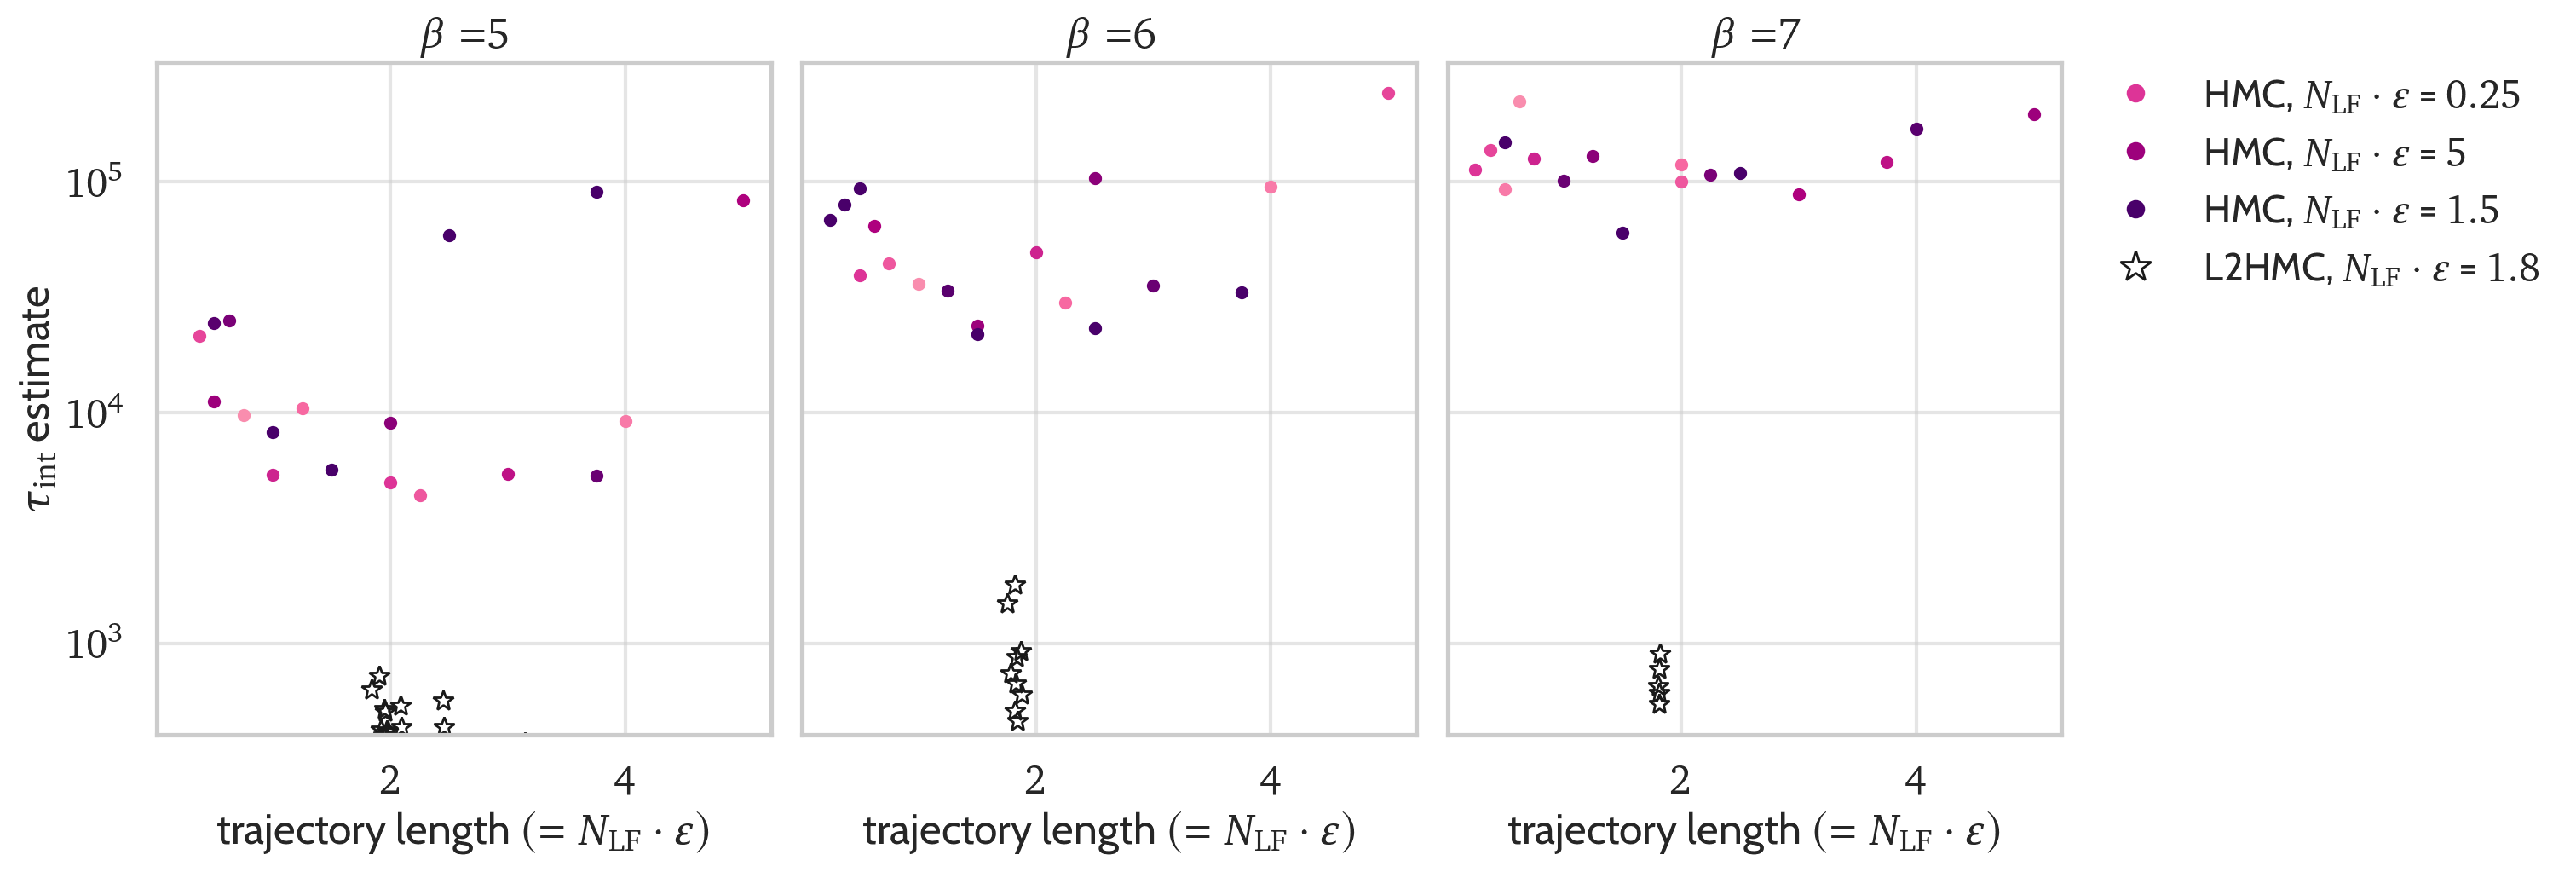

In [394]:
from config import PLOTS_DIR

sns.set_palette('bright')
cmap = 'RdPu'

best_l2hmc = {}
best_hmc = {}
# (N_lf, eps)
#worst_l2hmc = {}
worst_hmc = {}
err_l2hmc = {}
err_hmc = {}
avg_l2hmc = {}
avg_hmc = {}
betas = [5., 6., 7.]
traj_lens = np.array([0.25, 1.5, 5.])

num_plots = len(list(tint_data.keys()))
#fig, axes = plt.subplots(ncols=num_plots, sharey='row', sharex=True, figsize=(14, 4))
fig, axes = plt.subplots(ncols=num_figs, sharey='row', sharex=True, figsize=(15, 5), constrained_layout=True)
for idx, (key, val) in enumerate(tint_data.items()):
    ax = axes[idx]
    beta = key
    
    hmc_data = val['hmc']
    hdata_ = {k[0] * k[1]: v for k, v in hmc_data.items()}
    htlens = {k: k[0] * k[1] for k in hmc_data.keys()}
    hdata_ = dict(sorted(hdata_.items()))
    
    num_items = len(list(hdata_.keys()))
    midpt = num_items // 2
    cmap = plt.get_cmap(cmap, num_items + 10)
    hmc_arr = np.array(list(hdata_.values()))
    hmc_arr = hmc_arr[hmc_arr > 500]
    hmc_avg = np.mean(hmc_arr)
    hmc_err = np.std(hmc_arr)
    err_hmc[key] = hmc_err
    avg_hmc[key] = hmc_avg
    for jdx, (k, v) in enumerate(hmc_data.items()):
        lf, eps = k
        if v < 10:
            continue
            
        #lf, eps = k
        #traj_len = lf * eps
        traj_len = htlens[k]
            
        if np.abs(traj_len - 0.25) < 0.1 or np.abs(traj_len - 1.5) < 0.2 or np.abs(traj_len - 5.) < 0.1:
            label = f'HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon$ = " 
            label += f'${{{traj_len:.2g}}}$'
            
        #if idx == num_plots - 1 and jdx in [0, midpt, num_items - 1]:  # and idx in good_idxs:
        #    label = f'HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon$ = " 
        #    label += f'${{{traj_len:.2g}}}$'
        else:
            label = None
        #label = 'HMC' if jdx == 0 else None
        
        
        _ = ax.plot(traj_len, lf * v, '.', color=cmap(jdx+10), label=label, lw=0.8)
        #_ = ax.errorbar(traj_len, v, '.', color=cmap(jdx+10), label=label, lw=0.8)
    
    l2hmc_data = val['l2hmc']
    ldata_ = {k[0] * k[1]: v for k, v in l2hmc_data.items()}
    ltlens = {k: k[0] * k[1] for k in l2hmc_data.keys()}
    ldata_ = dict(sorted(ldata_.items()))
    if beta == 5:
        l2hmc_arr = np.array([i for i in list(ldata_.values()) if i < 100])
    else:
        l2hmc_arr = np.array([i for i in list(ldata_.values()) if i < 200])
    l2hmc_avg = np.mean(l2hmc_arr)
    l2hmc_err = np.std(l2hmc_arr)
    err_l2hmc[key] = l2hmc_err
    avg_l2hmc[key] = l2hmc_avg
    # err_l2hmc[key] = np.std(np.array(list(l2hmc_data.values())))
    # avg_l2hmc[key] = np.mean(np.array(list(l2hmc_data.values())))
    #best = np.inf
    for jdx, (k, v) in enumerate(l2hmc_data.items()):
        lf, eps = k
        
        if beta == 5.:
            if v > 100:
                continue
        if v > 200:
            continue
            
        traj_len = ltlens[k]
        #label = 'L2HMC' if jdx == 0 else None
        if jdx == 0:
            label = r"L2HMC, $N_{\mathrm{LF}} \cdot \varepsilon$ = " 
            label += f'${{{traj_len:.2g}}}$'
        else:
            label = None
        #lf, eps = k
        #traj_len = lf * eps
        
        _ = ax.plot(traj_len, lf * v, '*', label=label, color='k', fillstyle='none')
        
    _ = ax.set_xlabel('trajectory length ' + r"$(=N_{\mathrm{LF}} \cdot \varepsilon)$")
    _ = ax.set_yscale('log')
    _ = ax.set_title(r"$\beta=$" + beta_str[beta])
    if idx == 0:
        _ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
    if idx == num_plots - 1:
        #_ = ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.04), frameon=False, markersize=1.5)
        _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5, frameon=False)
for ax in axes:
    _ = ax.grid(True, alpha=0.5)
    
outfile = os.path.join(tint_plots_dir, f'tau_int_scatter_beta{beta}'.replace('.', '') + '.pdf')
print(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=400, bbox_inches='tight')

In [392]:
%debug

> <ipython-input-391-67d97c5af212>(64)<dictcomp>()
     62     l2hmc_data = val['l2hmc']
     63     ldata_ = {k[0] * k[1]: v for k, v in l2hmc_data.items()}
---> 64     ltlens = {k: k[0] * k[1] for k in l2hmc_data.items()}
     65     ldata_ = dict(sorted(ldata_.items()))
     66     if beta == 5:

ipdb> l2hmc_data.keys()
dict_keys([(10, 0.19424471), (10, 0.19424184), (10, 0.1957567), (10, 0.19395266), (10, 0.191584), (10, 0.18413678), (10, 0.19014968), (10, 0.1970841), (10, 0.19755399), (10, 0.19559464), (10, 0.19497973), (10, 0.18409148), (10, 0.19657207), (10, 0.20836465), (10, 0.20908755), (10, 0.20942947), (10, 0.31429398), (10, 0.11966534), (10, 0.24481377), (10, 0.24578927)])
ipdb> quit


Saving figure to: /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/2020-12-22/tau_int_vs_beta.pdf


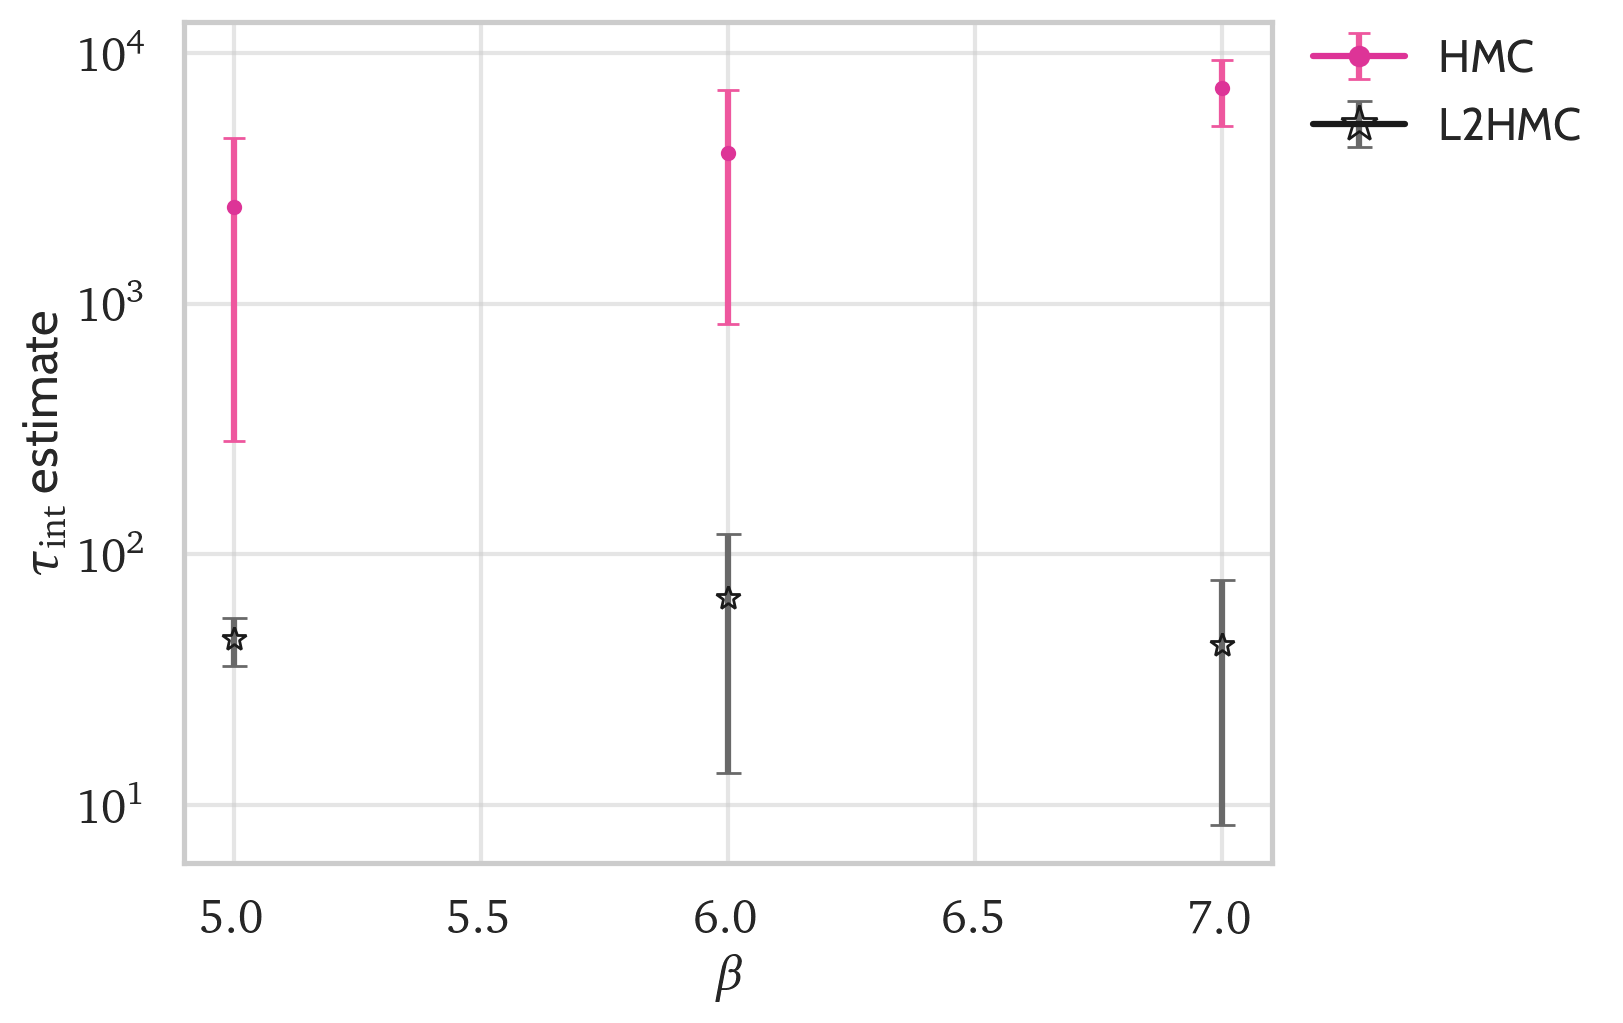

In [389]:
sns.set_style('whitegrid')
c4 = cmap(15)

#fig, ax = plt.subplots()
fig, ax = plt.subplots(ncols=1, figsize=(8, 5), constrained_layout=True)
for idx, (key, val) in enumerate(avg_hmc.items()):
    label = 'HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_hmc[key], marker='.', ls='-', color=c4, label=label, ecolor=cmap(13), capsize=4.)
    #_ = ax.errorbar(key, val, marker='.', ls='-', color='C0', label=label)
    
for idx, (key, val) in enumerate(avg_l2hmc.items()):
    label = 'L2HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_l2hmc[key], marker='*', color='k', fillstyle='none', ls='-', label=label, ecolor='dimgrey', capsize=4.5)
    #_ = ax.plot(key, val, marker='.', color='k', ls='-', fillstyle='none', label=label)
    
_ = plt.grid(True, alpha=0.5)
_ = ax.set_yscale('log')
_ = ax.set_xlabel(r"$\beta$")
_ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
#_ = ax.set_title(r"$\beta=$" + beta_str[beta])
_ = ax.legend(loc='upper left', markerscale=1.5, frameon=False, bbox_to_anchor=(1.0, 1.03))
outfile = os.path.join(tint_plots_dir, f'tau_int_vs_beta.pdf')
print(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=400, bbox_inches='tight')


In [186]:
#y = q[None, :]
y = qarr
#y = qarr[0]
print(y.shape)
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
#gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    #gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    
    
y_hmc = qarr_hmc
#y = qarr[0]
print(y_hmc.shape)
# Compute the estimators for a few different chain lengths
N_hmc = np.exp(np.linspace(np.log(100), np.log(y_hmc.shape[1]), 10)).astype(int)
#gw2010_hmc = np.empty(len(N_hmc))
new_hmc = np.empty(len(N_hmc))
for i, n in enumerate(N_hmc):
    #gw2010_hmc[i] = autocorr_gw2010(y_hmc[:, :n])
    new_hmc[i] = autocorr_new(y_hmc[:, :n])

# Plot the comparisons
#plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="L2HMC")
plt.loglog(N_hmc, new_hmc, "o-", label="HMC")
ylim = plt.gca().get_ylim()
#plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

(2048, 4000)


NameError: name 'qarr_hmc' is not defined

In [ ]:
q_hmc[5.0].keys()

In [ ]:
q_hmc[5.0][(20, 0.05)]

In [16]:
dqi_stats_l2hmc, dqi_avgs_l2hmc, dqi_errs_l2hmc = dq_stats(dqi_l2hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (10, 0.19424471), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19424471), (2500, 2048)
.....key, avg: (10, 0.19424471), 0.12506499886512756 +/- -0.014034612425984958
.....key, val.shape: (10, 0.19657207), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19657207), (2500, 2048)
.....key, avg: (10, 0.19657207), 0.10240905731916428 +/- -0.012410583155360652
------------------------------------------------------------------------------------------------------------------------
key: 6.0...
.....key, val.shape: (10, 0.18413678), (5000, 2048)
.....key, therm_arr.shape: (10, 0.18413678), (2500, 2048)
.....key, avg: (10, 0.18413678), 0.07840519398450851 +/- -0.010606209880734237
.....key, val.shape: (10, 0.187783), (5000, 2048)
.....key, therm_arr.shape: (10, 0.187783), (2500, 2048)
.....key, avg: (10, 0.187783), 0.05909442901611328 +/- -0.009

In [17]:
dqi_stats_hmc, dqi_avgs_hmc, dqi_errs_hmc = dq_stats(dqi_hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (20, 0.05), (5000, 512)
.....key, therm_arr.shape: (20, 0.05), (2500, 512)
.....key, avg: (20, 0.05), 0.014459621161222458 +/- -0.004154317691268261
.....key, val.shape: (20, 0.025), (5000, 512)
.....key, therm_arr.shape: (20, 0.025), (2500, 512)
.....key, avg: (20, 0.025), 0.007725532166659832 +/- -0.003002356036324596
.....key, val.shape: (20, 0.25), (5000, 512)
.....key, therm_arr.shape: (20, 0.25), (2500, 512)
.....key, avg: (20, 0.25), 0.0006556513835676014 +/- -0.000562246875882748
.....key, val.shape: (15, 0.1), (5000, 512)
.....key, therm_arr.shape: (15, 0.1), (2500, 512)
.....key, avg: (15, 0.1), 0.017396004870533943 +/- -0.004640591166366902
.....key, val.shape: (20, 0.1), (5000, 512)
.....key, therm_arr.shape: (20, 0.1), (2500, 512)
.....key, avg: (20, 0.1), 0.02262517437338829 +/- -0.005283789071881982
.....key, val.shape:

In [69]:
%store q_hmc
%store q_l2hmc
%store dqi_hmc
%store dqi_l2hmc

Stored 'q_hmc' (AttrDict)
Stored 'q_l2hmc' (AttrDict)
Stored 'dqi_hmc' (AttrDict)
Stored 'dqi_l2hmc' (AttrDict)


In [73]:
hmc_df = pd.DataFrame().from_dict({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_hmc.items()
})
hmc_df.head()

5.0  \
20 0.050  [-1.0000002, 1.9999996, -5.3123694e-07, -1.062...   
   0.025  [-1.0000006, -7.0, -3.0, 2.0000007, -6.071279e...   
   0.250  [3.7945494e-08, -1.8972747e-07, -1.0000004, 2....   
15 0.100  [-0.99999976, -1.5178198e-07, 0.9999998, -0.99...   
20 0.100  [-1.0000001, -1.1383648e-07, -6.071279e-07, 0....   

                                                        7.0  \
20 0.050  [-1.9999992, -1.0000001, 0.9999996, 0.99999946...   
   0.025  [1.0000002, -3.0000002, -4.0000005, -1.9999995...   
   0.250  [-1.0000001, -0.99999946, 4.9999995, -3.000000...   
15 0.100  [0.99999976, -1.0000005, 0.99999994, 0.9999996...   
20 0.100  [0.99999946, 2.0, 2.0, 0.9999992, -1.9999996, ...   

                                                        6.0  \
20 0.050  [-1.0000002, -1.9999992, -1.1383648e-07, -2.00...   
   0.025  [-0.99999994, -2.0000002, 1.9999999, -2.0, -1....   
   0.250  [0.99999994, -0.99999994, 0.99999946, -3.00000...   
15 0.100  [1.0, 0.9999996, -1.0000007, 9.865828e-07, -1....   
20 0.100  [3.7945494e-08, 2.9999993, -2.0000007, 0.99999...   

                                                        4.5  \
20 0.050  [-3.7945495e-07, 1.9999999, 1.9999999, -3.0356...   
   0.025  [1.9999999, 7.589099e-08, 1.9999994, -3.999999...   
   0.250  [-1.0, 3.0000005, 0.99999994, -5.8815516e-07, ...   
15 0.100  [-1.9999996, -7.589099e-07, 0.9999996, 0.99999...   
20 0.100  [-2.0000002, 1.0000002, -6.2610064e-07, -1.999...   

                                                        5.5  \
20 0.050  [-2.2767296e-07, -1.0000002, 0.9999995, -1.214...   
   0.025  [-0.9999997, 1.0000001, -1.0000001, -2.0000002...   
   0.250  [-1.0000001, -6.450734e-07, -2.0000005, 1.0, 2...   
15 0.100  [-2.0000002, -0.99999946, 1.9999995, -2.999999...   
20 0.100  [-8.537736e-07, -1.0000008, 1.0000002, -1.0000...   

                                                        4.0  3.0  
20 0.050  [-1.0000005, -3.7945494e-08, -0.9999995, -6.45...  NaN  
   0.025                                                NaN  NaN  
   0.250  [-3.4150943e-07, -2.0000002, 0.99999946, 5.312...  NaN  
15 0.100  [-1.9999996, 1.9999996, 2.9999995, 4.553459e-0...  NaN  
20 0.100  [1.0000002, -2.0000002, -1.0, 0.99999976, -3.0...  NaN

In [78]:
l2hmc_df = xr.DataArray({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_l2hmc.items()
})
l2hmc_df

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x1042d35780>,
      dtype=object)

In [82]:
import xarray as xr
from utils.data_utils import therm_arr

therm_frac = 0.25

#hmc_xarr = {}
hmc_xarr = []
for beta, data in q_hmc.items():
    if beta not in q_l2hmc.keys():
        continue
        
    for k, v in data.items():
        num_steps, num_chains = v.shape
        arr, steps = therm_arr(v, therm_frac=therm_frac)
        chains = np.arange(num_chains)
        coords = {
            'chain': chains,
            'draw': steps,
            'beta': beta,
            'leapfrog': k[0],
            'eps': k[1],
        }
        hmc_xarr.append(xr.DataArray(arr.T, dims=['chain', 'draw'], coords=coords))

In [84]:
xr.merge(hmc_xarr)

ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name

In [ ]:
hmc_xarr

In [1]:
import xarray as xr

dataset = xr.Dataset({'l2hmc': l2hmc_df, 'hmc': hmc_df})
dataset

NameError: name 'l2hmc_df' is not defined

### Save boostrapped tunneling rate stats to avoid having to recompute

In [18]:
from config import LOGS_DIR

timestamp = io.get_timestamp()
date = io.get_timestamp('%Y-%m-%d')
outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')
io.check_else_make_dir([outdir, datadir, figsdir])

# +-------+
# | L2HMC |
# +-------+
intfile_l2hmc = os.path.join(f'dq_int_stats_l2hmc_{timestamp}.z')
io.savez(dqi_stats_l2hmc, intfile_l2hmc, name='dq_int_stats_l2hmc')

#sinfile_l2hmc = os.path.join(f'dq_sin_stats_l2hmc_{timestamp}.z')
#io.savez(dqs_stats_l2hmc, sinfile_l2hmc, name='dq_sin_stats_l2hmc')

# +-----+
# | HMC |
# +-----+
intfile_hmc = os.path.join(f'dq_int_stats_hmc_{timestamp}.z')
io.savez(dqi_stats_hmc, intfile_hmc, name='dq_int_stats_hmc')

#sinfile_hmc = os.path.join(f'dq_sin_stats_hmc_{timestamp}.z')
#io.savez(dqs_stats_hmc, sinfile_hmc, name='dq_sin_stats_hmc')

Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/data
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/figs
Saving dq_int_stats_l2hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_l2hmc_2020-12-09-235915.z.
Saving dq_int_stats_hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_hmc_2020-12-09-235915.z.


In [19]:
from config import LOGS_DIR
import utils.file_io as io

outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')

In [20]:
def load_dq_data(datafiles):
    data = {}
    for datafile in datafiles:
        print(f'Loading data from: {datafile}...')
        key = '_'.join(datafile.split('/')[-1].split('_')[:4])
        val = io.loadz(datafile)
        data[key] = val
    return  data

### Scatter plot of $\langle \delta\mathcal{Q}\rangle$ vs $\varepsilon$ for HMC, L2HMC

In [21]:
dqi_stats_l2hmc = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))
dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

print(f'hmc keys: {dqi_stats_hmc.keys()}')
print(f'l2hmc keys: {dqi_stats_l2hmc.keys()}')

hmc keys: dict_keys([5.0, 7.0, 6.0, 4.5, 5.5, 4.0, 3.0])
l2hmc keys: dict_keys([5.0, 6.0, 7.0])


In [22]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [23]:
%matplotlib inline

In [35]:
%matplotlib notebook

In [37]:
dqih.keys()

dict_keys([3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0])

In [38]:
dqih[5.0].keys()

dict_keys([(20, 0.05), (20, 0.025), (20, 0.25), (15, 0.1), (20, 0.1), (15, 0.2), (25, 0.2), (20, 0.3), (25, 0.025), (15, 0.05), (25, 0.3), (15, 0.3), (20, 0.2), (15, 0.25), (25, 0.25), (25, 0.15), (20, 0.15), (15, 0.025), (15, 0.15), (25, 0.05), (10, 0.025), (25, 0.1), (10, 0.3), (10, 0.1), (10, 0.2), (10, 0.25), (10, 0.05), (10, 0.15)])

In [ ]:
dqih[]

In [50]:
axes1.shape

(3,)

In [51]:
axes_grid.shape

(2, 3)

In [2]:
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['x', '', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

leapfrogs_l2hmc = [10]  # , 15, 20]
leapfrogs_hmc = [10, 15, 20, 25, 30]
keep_betas = [5., 6., 7.]
eps_cond = lambda eps: eps < 0.29


beta_dict = {
    2.0: r"$2$",
    3.0: r"$3$",
    4.0: r"$4$",
    4.5: r"$4.5$",
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}

lf_dict = {
    10: r"$10$",
    15: r"$15$",
    20: r"$20$",
    25: r"$25$",
    30: r"$30$",
}

plot_kwargs = {
    'markersize': 8.,
    'lw': 2.,
    'alpha': 1.,
    #'marker': '.',
}

plot_kwargs_hmc = copy.deepcopy(plot_kwargs)
plot_kwargs_l2hmc = copy.deepcopy(plot_kwargs)

plot_kwargs_l2hmc.update({'ls': '', 'color': 'k', 'marker': 'o'})
plot_kwargs_hmc.update({'ls': '-', 'marker': '.'})

lf_colors = plt.cm.get_cmap('Greys', 16)
lf_colors_l2hmc = 10 * ['#87ff00']

HMC_COLORS = np.array(9 * ['C1'])
L2HMC_COLORS = np.array(9 * ['C0'])

labels = {
    'hmc_int': r"HMC",
    'hmc_sin': r"HMC (sin)",
    'l2hmc_int': r"L2HMC",
    'l2hmc_sin': r"L2HMC (sin)",
}


subfig_idxs = ['(a.) ', '(b.) ', '(c.) ', '(d.) ']

dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

figsize = set_size(subplots=(2, 3))

#widths = [2, 3, 1.5]
#heights = [1, 3, 2]
#gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig6, f6_axes = plt.subplots(ncols=3, nrows=3, constrained_layout=True,
#        gridspec_kw=gs_kw)

gs_kw = {
    'height_ratios': [2.5, 1],
}

fig, axes_grid = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True,
                              sharex='col',
                              gridspec_kw=gs_kw)
axes = axes_grid[0, :].flatten()
axes1 = axes_grid[1, :].flatten()


# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
# axins = inset_axes(axes[-1], width="75%", height="27%", loc='upper left', borderpad=0.4)
# axins1 = inset_axes(axes[1], width="75%", height="27%", loc='upper left', borderpad=0.4)


#axins = inset_axes(axes[-1], width=5., height=1.5, bbox_to_anchor=(1.0, 1.01))
# Create an inset outside the axes

# axins = inset_axes(axes[-1], width="100%", height="100%",
#                    bbox_to_anchor=(1.05, .6, .5, .4),
#                    bbox_transform=axes[-1].transAxes, loc=2, borderpad=0)

# axins3 = inset_axes(ax3, width="100%", height="100%",
#                     bbox_to_anchor=(.7, .5, .3, .5),
#                     bbox_transform=ax3.transAxes)
#axins = inset_axes(axes[-1], width="100%", height="100%",
#                   bbox_to_anchor=(.7, .5, .3, .5),
#                   #bbox_to_anchor=(1.05, 0.1, .4, .6),
#                   bbox_transform=axes[-1].transAxes, borderpad=0.5)
#axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(axes[-1], axins, loc1=2, loc2=4, fc="none", alpha=0.7, ec='0.3', zorder=-20)


#axins = zoomed_inset_axes(axes[-1], 1, loc='upper left') #bbox_to_anchor=(1.0, 0), loc='upper left')  # zoom = 6

from mpl_toolkits.axes_grid1 import Grid

idx = 0
for kih, vih in dqih.items():
    #fig, ax = plt.subplots(constrained_layout=True)
    ax1 = axes1[idx]
    beta = kih
    if beta < 5.0 or beta not in keep_betas:
        continue
    # ====
    # NOTE:
    # vih = {
    #    (leapfrogs, eps): {
    #        'avg': avg, 'avg_std': avg_std,
    #        'err': err, 'err_std': err_std,
    #        'min': min, 'max': max,
    #    }
    # }
    #if beta not in dqi_stats_l2hmc.keys():
    #    continue
    try:
        ax = axes[idx]
    except IndexError or beta not in dqi_stats_l2hmc.keys():
        continue
        
    def get_plot_data(d):
        x = []
        y = []
        y_err = []
        for k, v in d.items():
            num_steps, eps = k
            if eps_cond(eps):
                x.append(eps)
                y.append(v['avg'])
                y_err.append(v['err'])
            
        return x, y, y_err
    
    def share_yaxes(row, base=0):
        
        #ylim = row[base].get_ylim()
        #yticklabels = ax.get_yticklabels()
        _ax = row[base]
        ylim = _ax.get_ylim()
        y0, y1 = ylim
        yticks = _ax.get_yticks()
        yticklabels = _ax.get_yticklabels()
        
        for ax in row[1:]:
            _ = ax.set_ylim(ylim)
            _ = ax.set_yticklabels([])
            _ = ax.set_yticks(yticks)

        return row
    
    dqil = dqi_stats_l2hmc.get(beta, None)
    if dqil is not None:
        # +-----------------------------------------------------+
        #   NOTE:
        #   ====
        #     dqil_ = {
        #         (Nlf, eps0): {'avg': ..., 'err': ..., },
        #         (Nlf, eps1): {'avg': ..., 'err': ..., },
        #     }
        # +-----------------------------------------------------+
        #dqil_ = sorted(dqil.items(), key=lambda x: x[0])
        _vil = dict(sorted(dqil.items(), key=lambda x: x[0][1]))
        _vil_ = {lf: {} for lf in leapfrogs_l2hmc}
        for k, v in _vil.items():
            for lf in leapfrogs_l2hmc:
                if k[0] == lf:
                    _vil_[lf][k] = v
                
        for jdx, lf in enumerate(leapfrogs_l2hmc):
            if lf not in _vil_.keys():
                continue
            if idx == 2:
                label = r"$N_{\mathrm{LF}} = $" + f'{lf_dict[lf]}, ' + 'L2HMC'
                #_ = axins.errorbar(xil, yil, yil_err, label=label, **plot_kwargs_l2hmc)
            else:
                label = None
            xil, yil, yil_err = get_plot_data(dict(sorted(_vil_[lf].items(), key=lambda x: x[0][1])))
            _ = ax.errorbar(xil, yil, yil_err, label=label, fillstyle='none', **plot_kwargs_l2hmc)
    
    _vih = dict(sorted(vih.items(), key=lambda x: x[0][1]))
    _vih_ = {lf: {} for lf in leapfrogs_hmc}
    for k, v in _vih.items():
        for lf in leapfrogs_hmc:
            if k[0] == lf:
                _vih_[lf][k] = v
    
    for jdx, lf in enumerate(leapfrogs_hmc):
        if lf not in _vih_.keys() or lf == 30:
            continue
            
        xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(),
                                                      key=lambda x: x[0][1])))
        if idx == 1:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins1.plot(xih, yih, label=label,
            #                 color=lf_colors(2*(jdx + 4)),
            #                 markersize=5., ls='', alpha=1., marker='.')
        if idx == 2:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins.plot(xih, yih, label=label,
            #                color=lf_colors(2*(jdx + 4)),
            #                markersize=5., ls='', alpha=1., marker='.')
        else:  # don't bother labeling, no legend
            label = None
            
        _ = ax.errorbar(xih, yih, yih_err,
                        #ls=':', marker='.',
                        label=label, color=COLORS[jdx],
                        **plot_kwargs_hmc)
        _xih_ = xih[:-1]
        _yih_ = yih[:-1]
        _yih_err_ = yih_err[:-1]
        _ = ax1.errorbar(_xih_, _yih_, _yih_err_,
                         capsize=1.5, alpha=0.6,
                         ls='', marker='.',
                         #ls=':', marker='.',
                         label=label, color=COLORS[jdx])  # color=lf_colors(jdx+8),
                         #**plot_kwargs_hmc)

    
        
            
    title_str = ' '.join([r"$\beta=$", beta_dict[beta]])
    _ = ax.set_title(title_str)
    
    timestamp = io.get_timestamp()
    #if idx == 0:
        #_ = ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', framealpha=0.4, fontsize='x-small')
    _ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotation='horizontal', ha='right')
    for ax in axes:
        #_ = ax.set_xlabel('')
        _ = ax.tick_params(grid_alpha=0.5)
    for ax in axes1:
        _ = ax.set_xlabel(r"$\varepsilon$")
        _ = ax.tick_params(grid_alpha=0.5)
        _ = ax.set_yscale('log')
        
    # for ax in axes1[1:]:
    #     ylim = ax
    #     yticks = ax.get_yticks()
    #     yticklabels = ax.get_yticklabels()
    #     _ = ax.set_yticks(yticks)
    #     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
        
        #_ = ax.set(framealpha=0.5)
        #_ = ax.set_xlim((0.0245, 0.255))
        #_ = ax.set_ylim((0, ax.get_ylim()[-1]))
        
    idx += 1
    
    
    
#_ = share_yaxes(axes)

# for ax in axes1[1:]:
#     #_ = ax.set_autoscaley_on(True)
#     yticks = ax.get_yticks()
#     yticklabels = ax.get_yticklabels()
#     _ = ax.set_yticks(yticks)
#     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
#def share_xaxes(row, base=0):
#    xmin, xmax = row[base].get_xlim()
#    for plot in row:
#        plt.set_xlim((xmin, xmax))
        

    
# ins_xlim = axins.get_xlim()
# ins_ylim = axins.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins.set_xlim((x0, 0.2101))
# _ = axins.set_ylim((y0, ins_ylim[-1]))
# _ = ax.grid()
# _ = axins.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1.0, color='w', length=0.5)
# _ = axins.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins.xaxis.get_major_locator().set_params(nbins=3)


# ins_xlim = axins1.get_xlim()
# ins_ylim = axins1.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins1.set_xlim((x0, 0.2101))
# _ = axins1.set_ylim((y0, ins_ylim[-1]))
# _ = axins1.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1., color='w', length=0.5)
# _ = axins1.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins1.xaxis.get_major_locator().set_params(nbins=3)



#_ = axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

    
# x1, x2, y1, y2 = 0.01, 0.12, -0.0005, 0.0005
#_ = axins.set_xlim(0.065, 0.165)
#_ = axins.set_ylim(-0.0005, 0.0010)

# # fix the number of ticks on the inset axes
#_ = axins.xaxis.get_major_locator().set_params(nbins=2)

#_ = plt.setp(axins.get_xticklabels(), visible=False)
#_ = plt.setp(axins.get_yticklabels(), visible=False)
#for ax in axes1:
#    ax.set_yscale('log')
    
   

    #yticklabels = ax.get_yticklabels()
    #ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})

_ = axes[0].legend(loc='upper left', framealpha=0.4, fontsize='x-small')

fname = f'dq_vs_beta'
out_file = os.path.join(PLOTS_DIR, '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')

out_file = os.path.join(TEX_FIGURES_DIR, 'tunneling_rates', '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')
#plt.show()
#import tikzplotlib
#_ = plt.tight_layout()
#out_file = os.path.join(figsdir, f'dq_lf10_stats_beta_{timestamp}_tikz'.replace('.', '') + '.tex')
#tikzplotlib.clean_figure(fig)
#tikzplotlib.save(out_file)
#_ = fig.suptitle(r"$N_{\mathrm{LF}} = $" + lf_dict[leapfrogs])

#dqsh = sorted(dqs_stats_hmc.items(), key=lambda x: x[0])
#nrows = len(dqi_stats_l2hmc.keys())
#fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(11, 8), constrained_layout=True)
# (4, 3)
#fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6), constrained_layout=True)
#for idx, ((kih, vih), (ksh, vsh)) in enumerate(zip(dqih, dqsh)):
#if idx == 0:
#li_label = labels['l2hmc_int'] + r"$N_{\mathrm{LF}} = $"
#ls_label = labels['l2hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hs_label = labels['hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hi_label = labels['hmc_int'] + r"$N_{\mathrm{LF}} = $"
#else:
#    hi_label = hs_label = li_label = ls_label = None


#_vih_ = {k: v for k, v in _vih.items() if k[0] == leapfrogs}


tf.__version__: 1.15.0


NameError: name 'dqi_stats_hmc' is not defined

In [34]:
ax = axes1[0]

In [ ]:
%debug

In [66]:
%matplotlib notebook

In [76]:
%debugkj

> <ipython-input-30-a98819713ef3>(2)<module>()
      1 dqi_stats_l2hmc[3.0] = {
----> 2     k: v for k, v in dqi_stats_l2hmc[3.0].items() if v['avg'] > 0.5
      3 }
      4 dqi_stats_l2hmc

ipdb> q


In [77]:
lf_colors(1)

(0.9282913165266107, 0.9282913165266107, 0.9282913165266107, 1.0)

In [ ]:
plt.legend()

In [70]:
%debug

> <ipython-input-69-11ca2af3b029>(131)<module>()
    129         try:
    130             xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(), key=lambda x: x[0][1])))
--> 131             _ = ax.errorbar(xih, yih, yih_err, label=hi_label + f'{lf_dict[lf]}',
    132                             alpha=0.7, ls='-', marker='.', color=lf_colors[jdx])
    133         except KeyError:

ipdb> lf_dict[lf]
'$10$'
ipdb> hi_label
ipdb> q


In [62]:
_vih_.keys()

dict_keys([10, 15, 20, 25, 30])

In [63]:
_vih_[10].keys()

dict_keys([(10, 0.05), (10, 0.1), (10, 0.15), (10, 0.2), (10, 0.25), (10, 0.3)])

In [66]:
beta

6.0

In [64]:
_vil.keys()

dict_keys([(10, 0.19465522)])

In [65]:
_vil_.keys()

dict_keys([(10, 0.19465522)])

In [32]:
ax.set_frame_on(False)

In [109]:
_ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotate=90)#, fontsize='large')


AttributeError: 'Text' object has no property 'rotate'

# OLD

## Plot distributions for different values of $\beta$

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


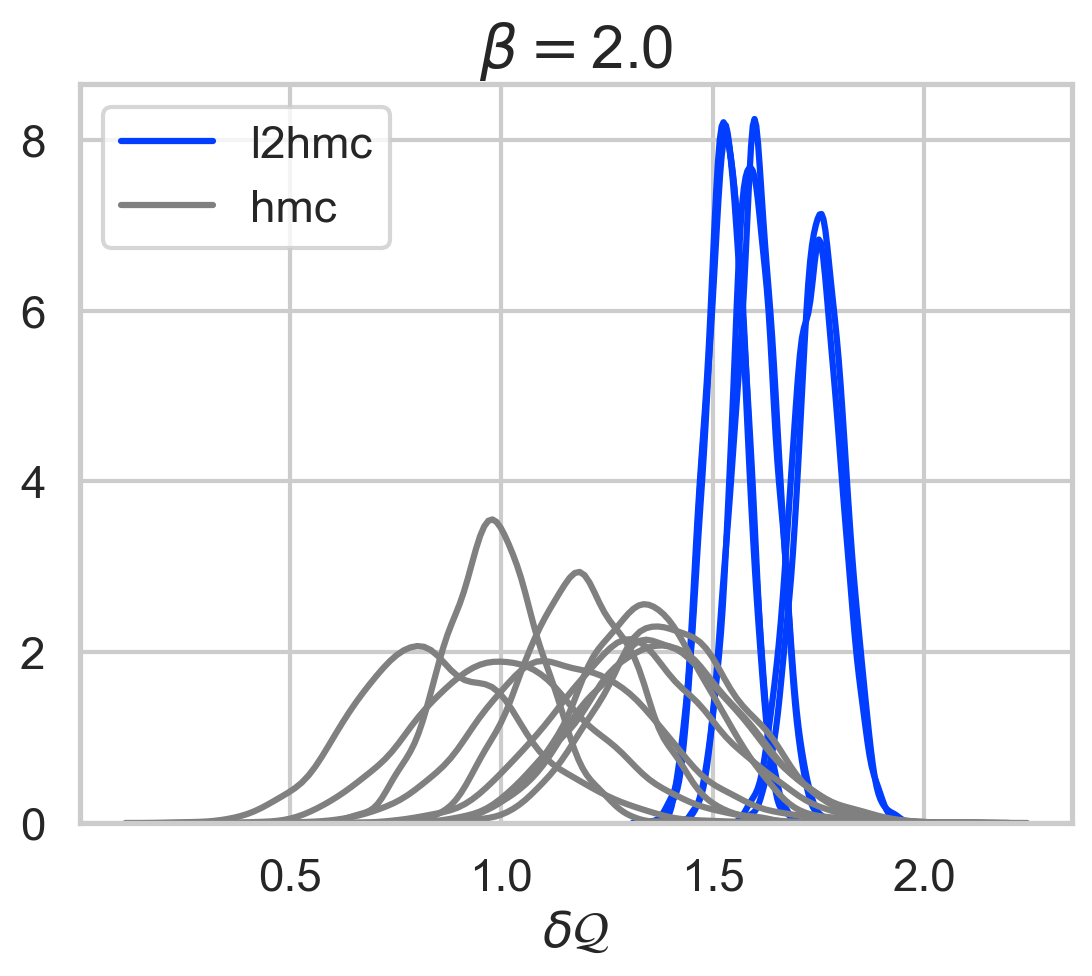

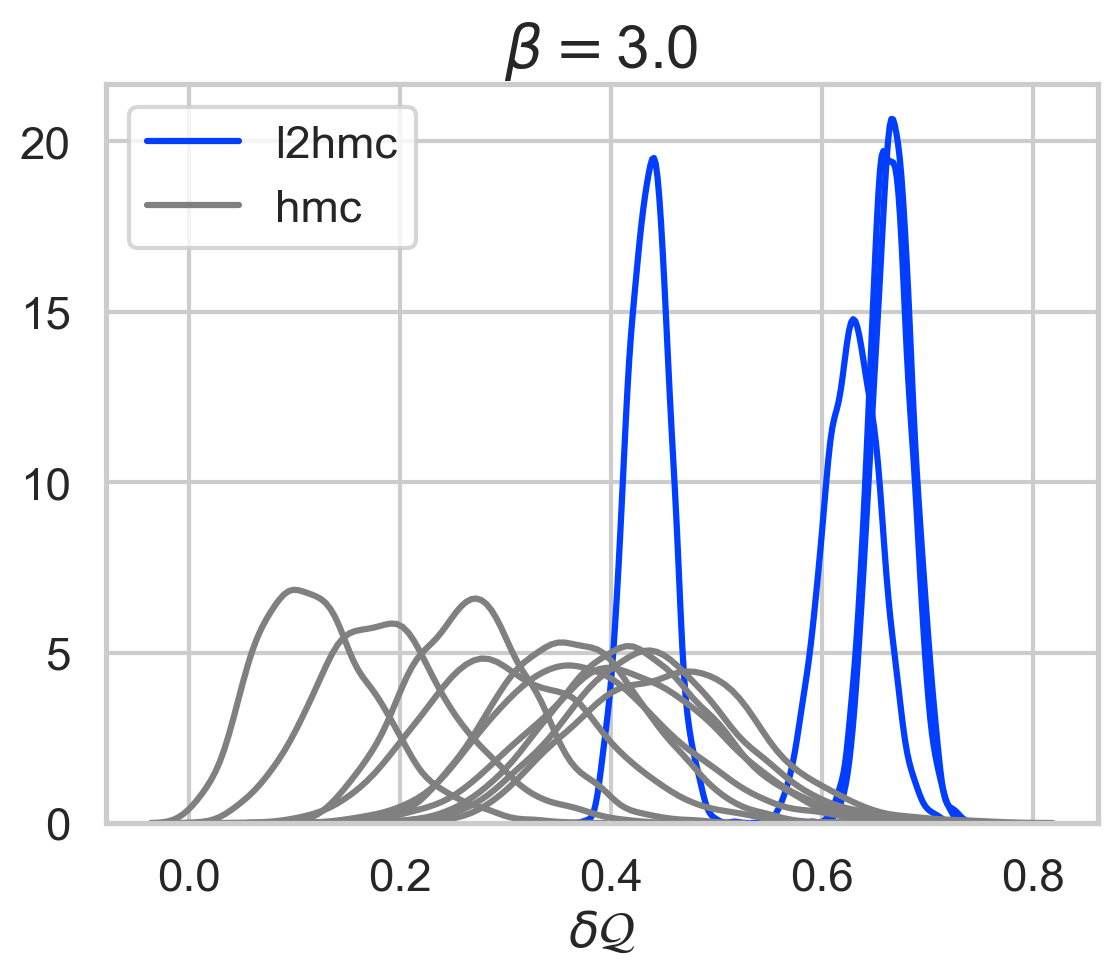

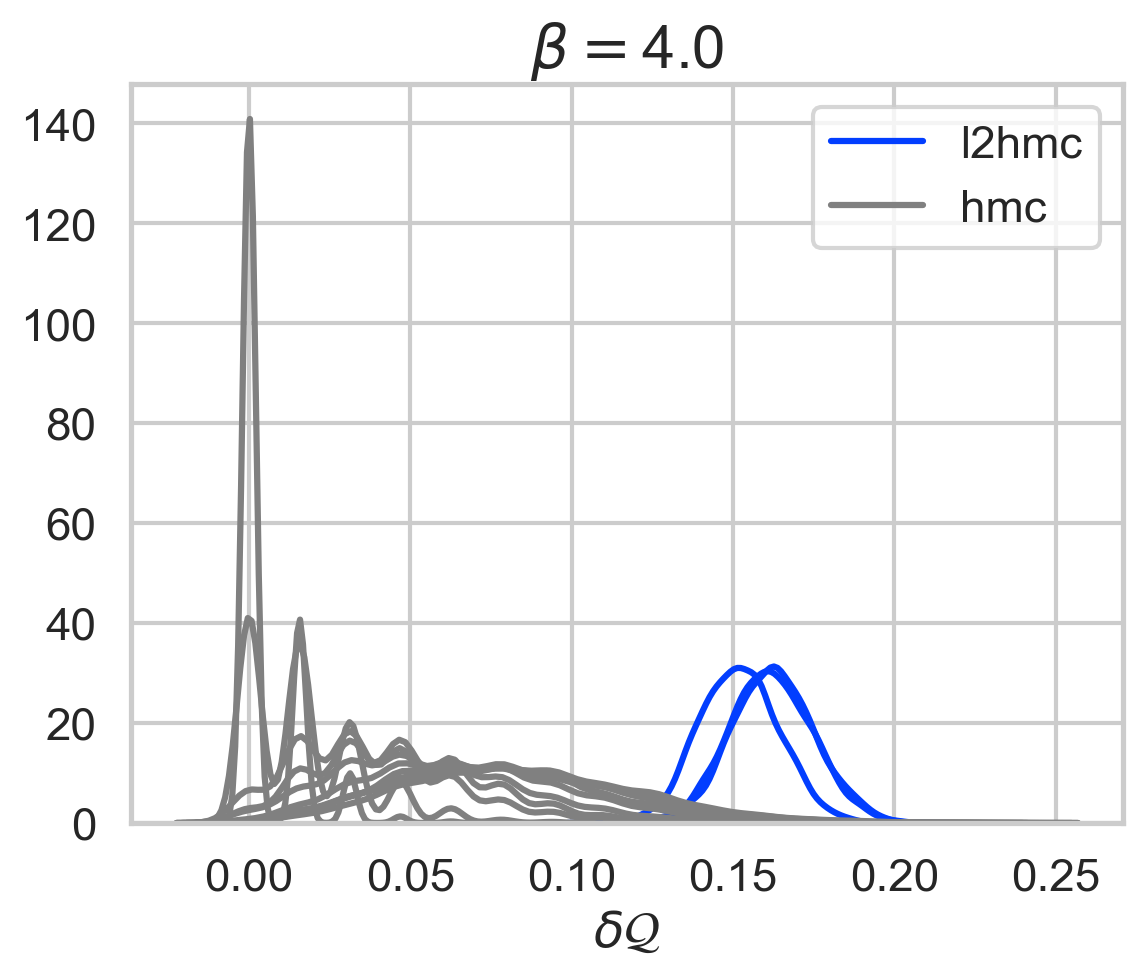

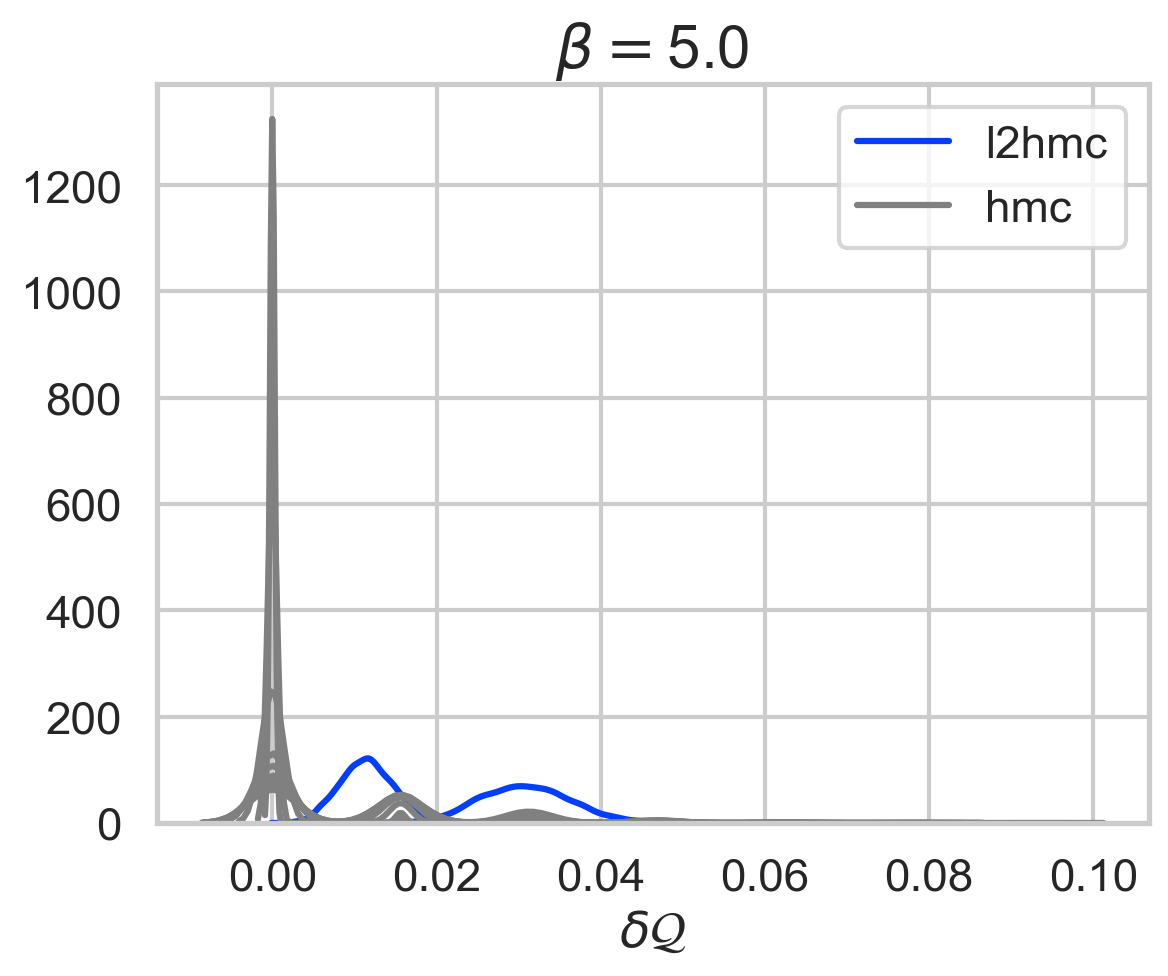

In [133]:
betas_l2hmc = list(dqi_l2hmc.keys())
betas_hmc = list(dqi_hmc.keys())

betas = sorted([x for x in betas_hmc if x in betas_l2hmc])

for beta in betas:
    fig, ax = plt.subplots()
    dqi_l = dqi_l2hmc[beta]
    dqi_h = dqi_hmc[beta]
    data = {}
    data = {'l2hmc': {}, 'hmc': {}}
    kl0 = list(dqi_l.keys())[0]
    for kl, vl in dqi_l.items():
        _, eps = kl
        try:
            data['l2hmc'].update({
                f'{eps:.3g}': vl
            })
        except KeyError:
            data['l2hmc'][f'{eps:.3g}'] = vl
            
        #label_ = 'l2hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kl == kl0:
            label = 'l2hmc'
        else:
            label = None
            
        _ = sns.distplot(vl[2500:, :].mean(axis=1), label=label, hist=False, color='C0')
        
    kh0 = list(dqi_h.keys())[0]
    for kh, vh in dqi_h.items():
        _, eps = kh
        try:
            data['hmc'].update({
                f'{eps:.3g}': vh
            })
        except KeyError:
            data['hmc'][f'{eps:.3g}'] = vh
    
        #label_ = 'hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kh == kh0:
            label = 'hmc'
        else:
            label = None
            
        _ = sns.distplot(vh[2500:, :].mean(axis=1), label=label, hist=False, color='gray')
        
    _ = ax.legend()
    _ = ax.set_xlabel(r"$\delta \mathcal{Q}$")
    #if beta == 2.0:
    #    _ = ax.set_xlim((0, 2.25))
    #elif beta == 3.0:
    #    _ = ax.set_xlim((0., 1.))
    #elif beta == 4.0:
    #    _ = ax.set_xlim((-0.01, 0.25))
    #elif beta == 5.0:
    #    _ = ax.set_xlim((0, 0.05))
        
    #_ = ax.set_xlim((0, 2.0))
    _ = ax.set_title(r"$\beta = $" + f'{beta}', fontsize='large')

# d3 = {'l2hmc': zl[:, :64], 'hmc': zh}

#fig, ax = plt.subplots()
#for key, val in d3.items():
#    _ = sns.distplot(val.mean(axis=1), label=key, hist=False)
    
_ = ax.legend(loc='best')
#_ = ax.set_xlim((0.5, ax.get_xlim()[1]))
#_ = ax.set_ylim((0, 2))
    

In [145]:
import matplotlib as mpl

In [ ]:
mpl.scale.LogScale(i)

In [84]:
axes.axes_all

## OLDER

<IPython.core.display.Javascript object>


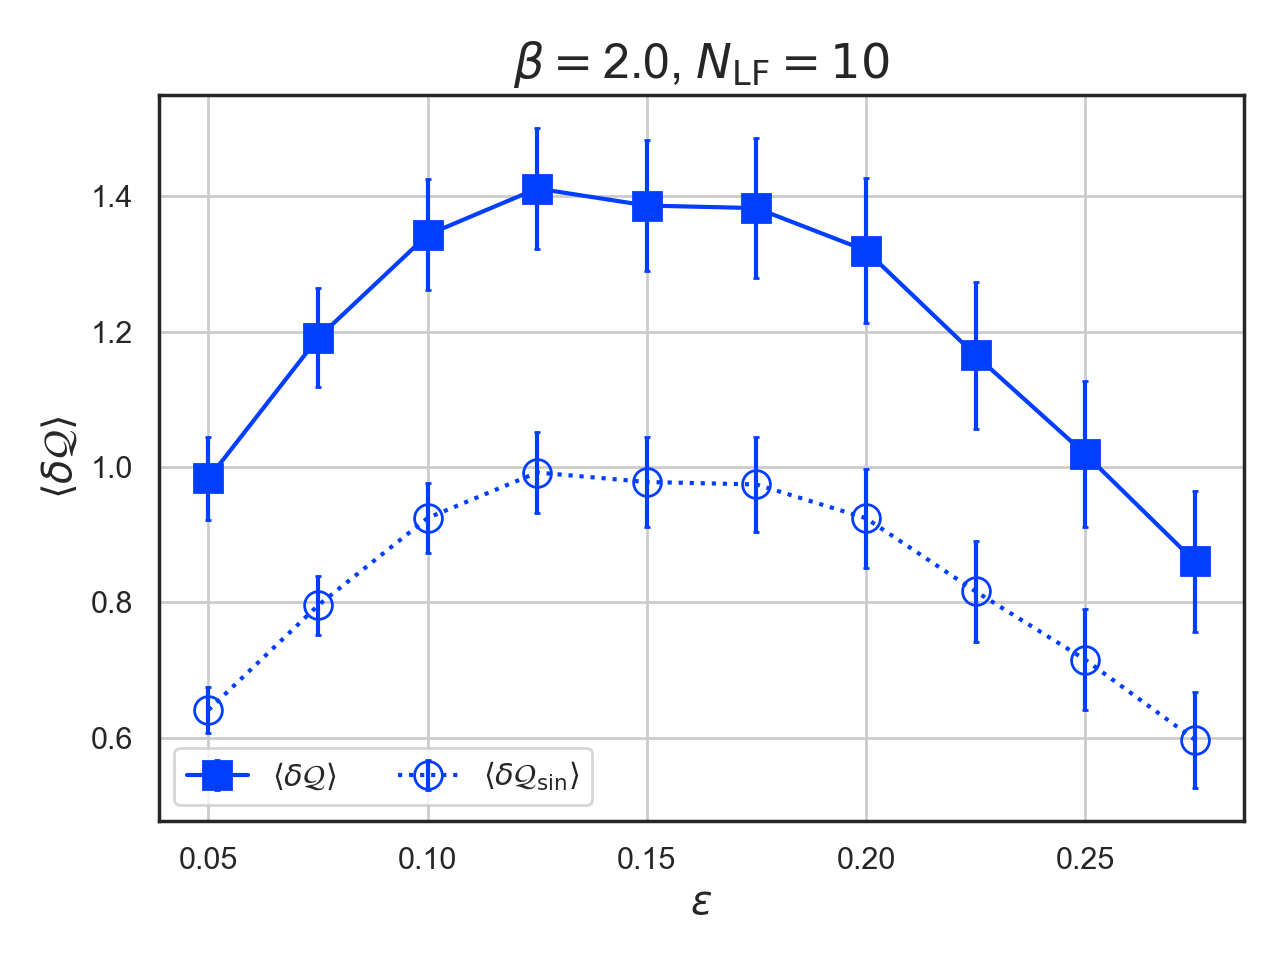

<IPython.core.display.Javascript object>


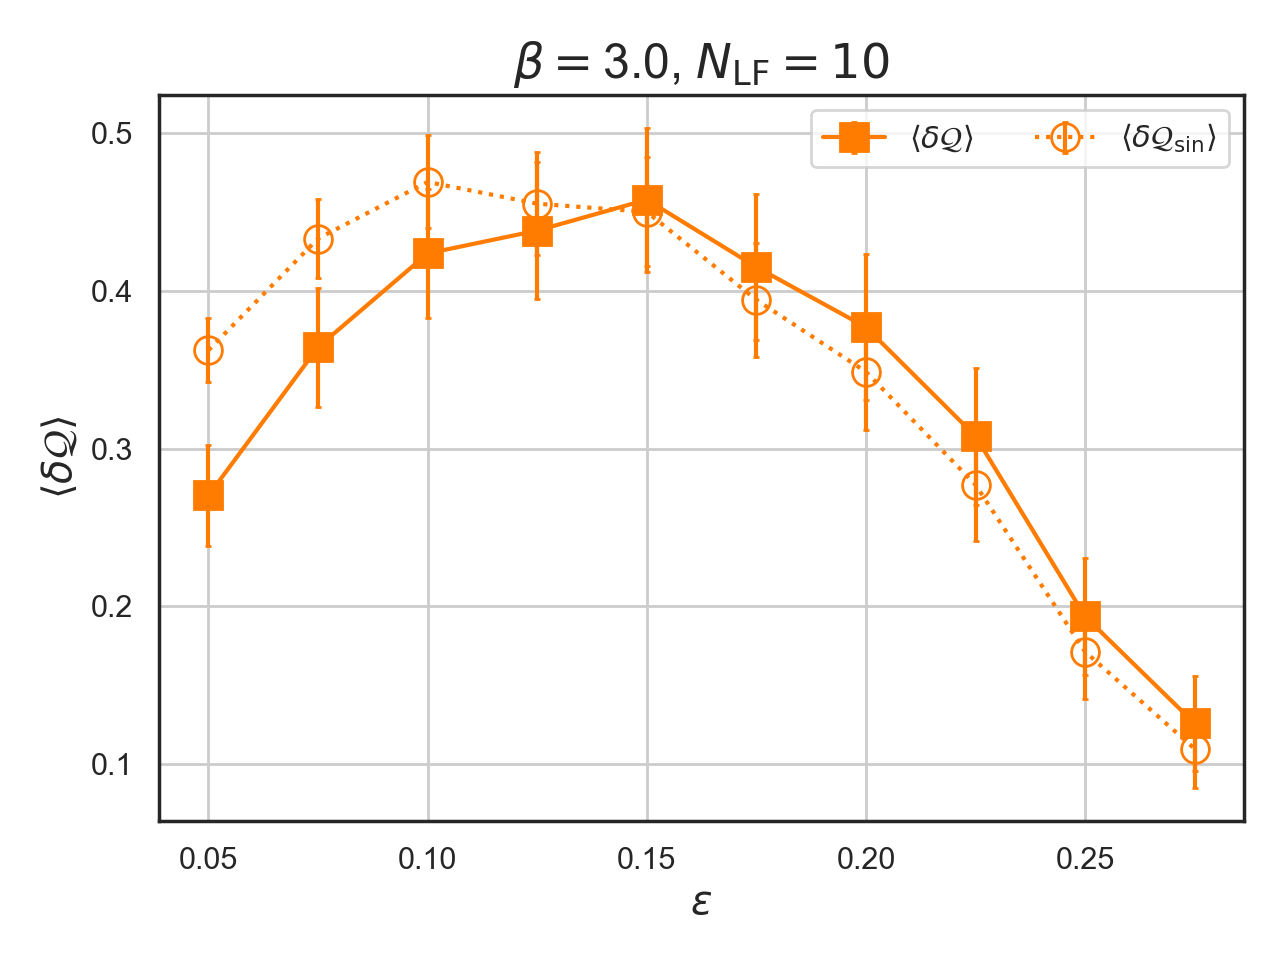

<IPython.core.display.Javascript object>


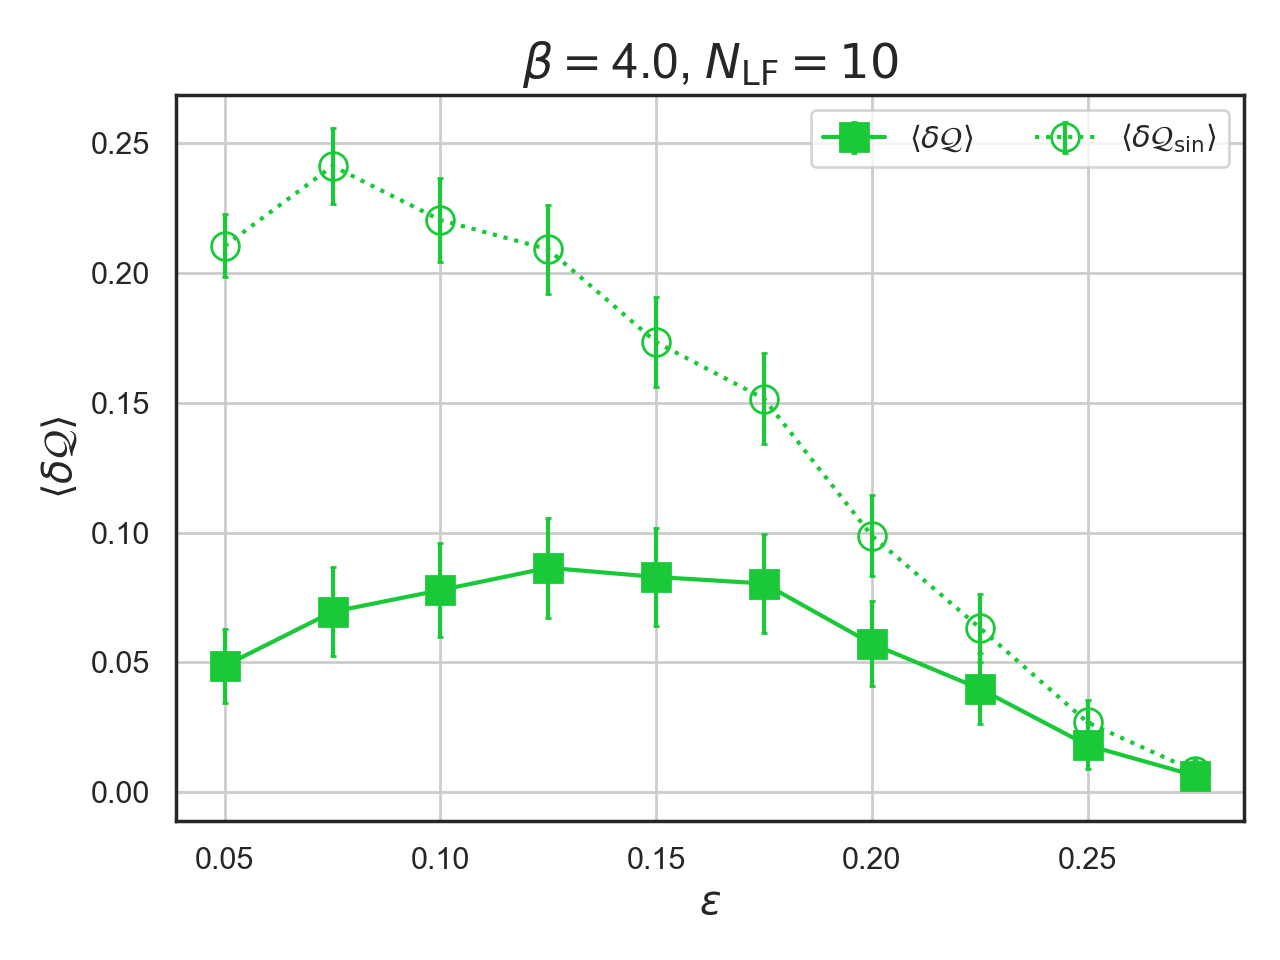

<IPython.core.display.Javascript object>


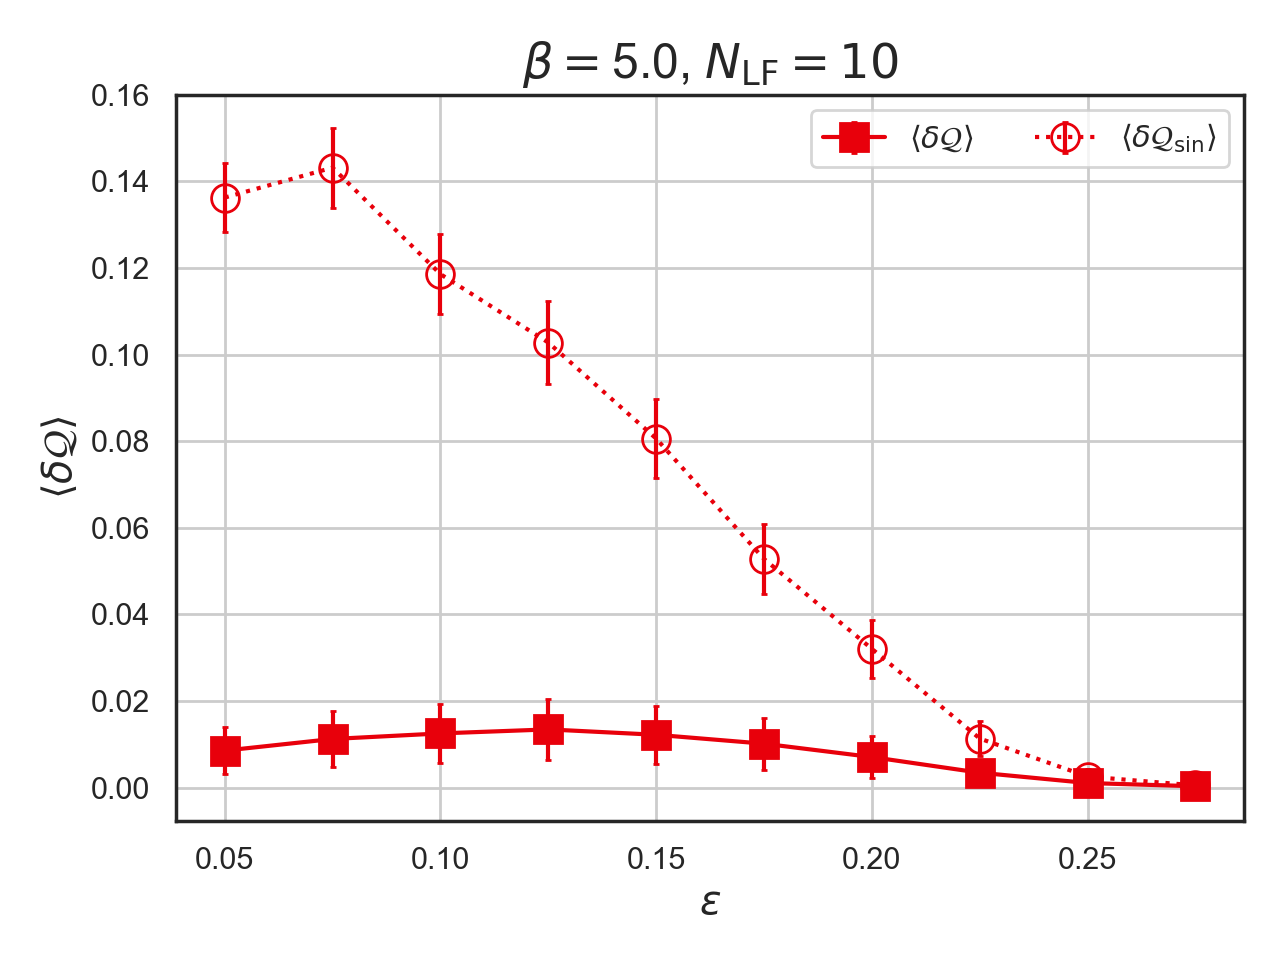

<IPython.core.display.Javascript object>


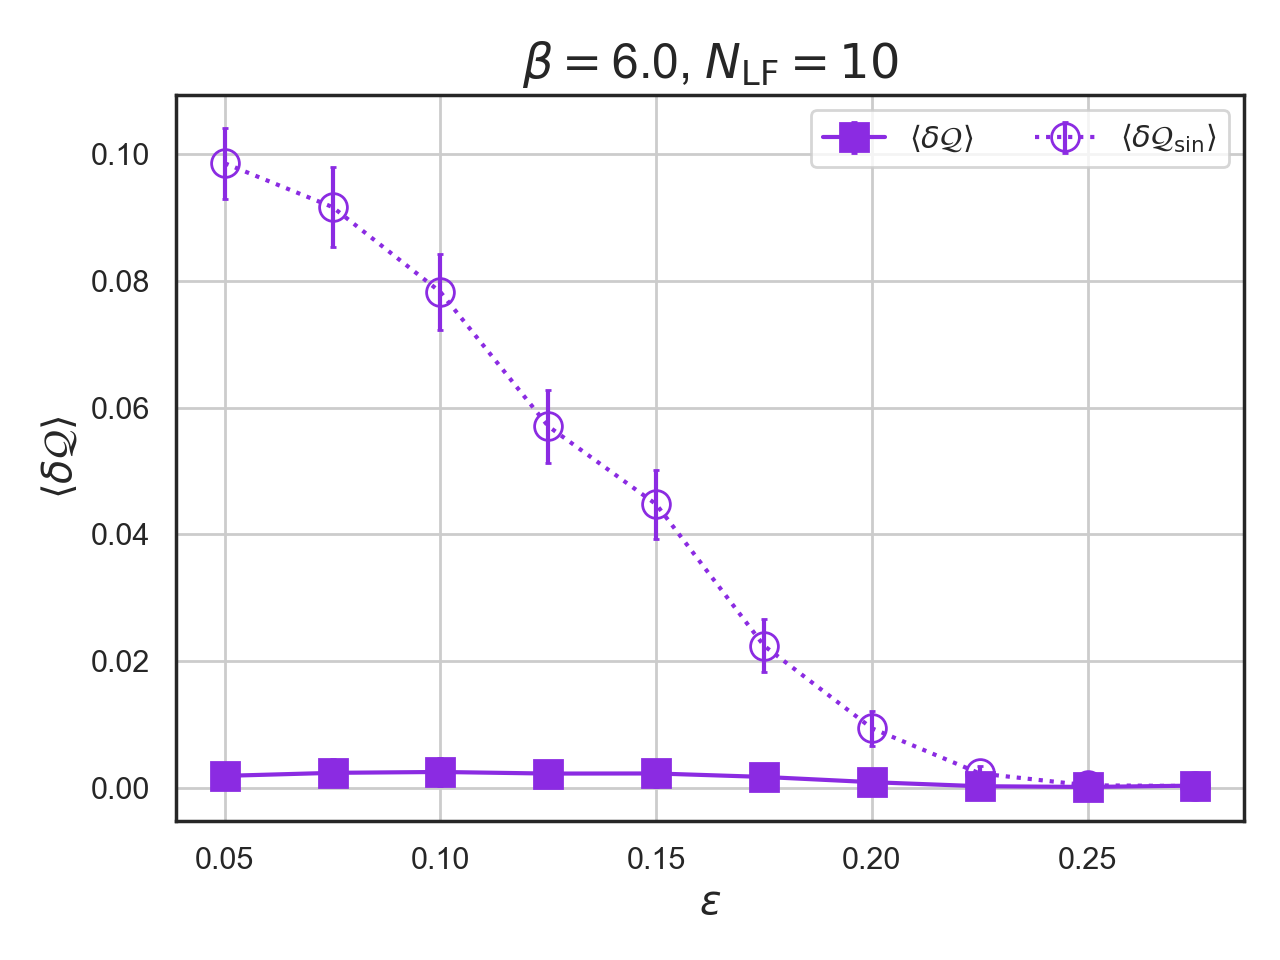

In [16]:
from config import MARKERS, COLORS

#plt.rcParams['savefig.facecolor']='red'
hmc_figs_dir = os.path.join(hmc_log_dir, 'dq_plots_new_2020_10_06')
io.check_else_make_dir(hmc_figs_dir)

dq_int = sorted(dq_int_stats.items(), key=lambda x: x[0])
dq_sin = sorted(dq_sin_stats.items(), key=lambda x: x[0])
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
for idx, ((kih, vih), (ksh, vsh), k) in enumerate(zip(dq_int, dq_sin)):
    fig, ax = plt.subplots()
    xi = []
    xs = []
    ys = []
    yi = []
    yi_err = []
    ys_err = []
    _vi = sorted(vi.items(), key=lambda x: x[0][1])
    _vs = sorted(vs.items(), key=lambda x: x[0][1])
    #for ki_, vi_ in vi.items():
    for ki_, vi_ in _vi:
        num_steps, eps = ki_
        xi.append(eps)
        yi.append(vi_['avg'])
        yi_err.append(vi_['err'])
        
    for ks_, vs_ in _vs:
        num_steps, eps = ks_
        xs.append(eps)
        ys.append(vs_['avg'])
        ys_err.append(vs_['err'])
        
    _ = ax.errorbar(xi, yi, yi_err, ls='-', marker='s',
                    capsize=1., markersize=10., fillstyle='full',
                    label=r"$\langle\delta\mathcal{Q}\rangle$",
                    color=COLORS[idx])
    _ = ax.errorbar(xs, ys, ys_err, ls=':', marker='o',
                    capsize=1., markersize=10., fillstyle='none',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    color=COLORS[idx])
    
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    _ = ax.set_title(r"$\beta = $" + f'{ki}, ' + r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
    _ = ax.legend(loc='best', ncol=2)
    _ = plt.tight_layout()
    _ = plt.grid(True)
    #_ = ax.set_yscale("log", nonposy='clip')
    timestamp = io.get_timestamp()
    out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_beta{ki}_{timestamp}'.replace('.', '') + '.png')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight') # , facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


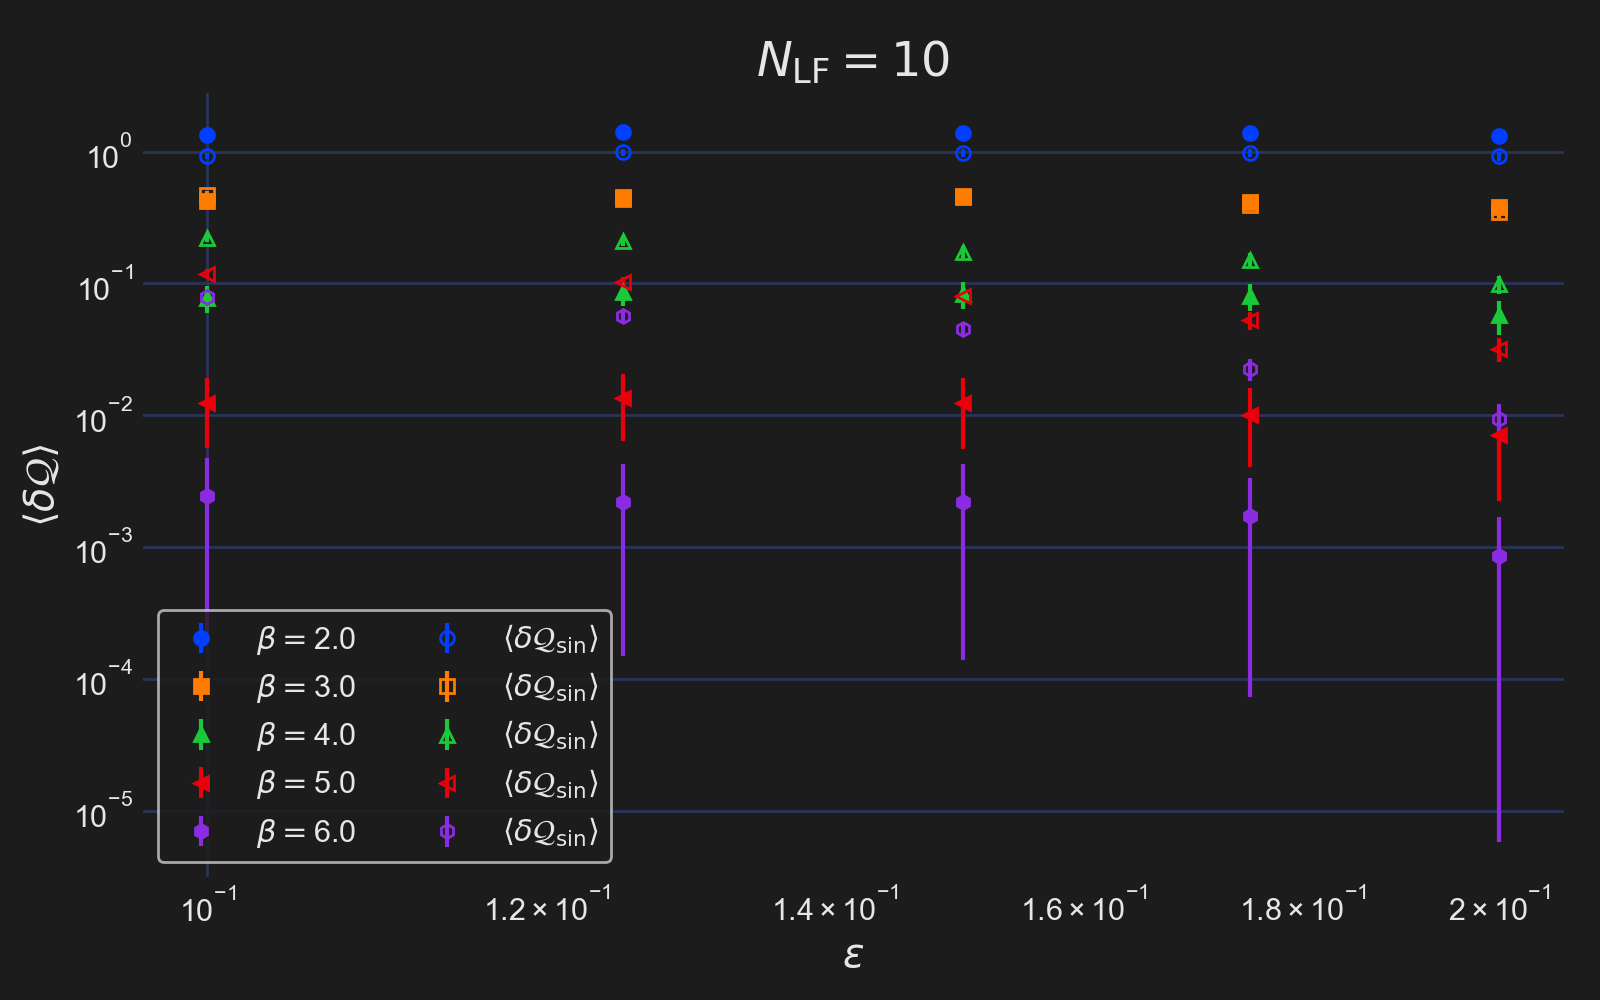

In [48]:
 
    
for idx, (key, val) in enumerate(sorted(dq_int_stats.items())):
fig, ax = plt.subplots(figsize=(8, 5), sharey=True)
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r'$\beta = $' + f'{key}',
                    markersize=5., fillstyle='full',
                    marker=MARKERS[idx], color=COLORS[idx])
    
    
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    #label=r'$\beta = $' + f'{key}',
                    fillstyle='none', markersize=5.,
                    marker=MARKERS[idx], color=COLORS[idx])
    #_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    #_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    #_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$")
    #_ = axes[1].legend(loc='best')

    #ax.set_title(r"$\beta = $" + f'{key}')
        
_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
_ = ax.legend(loc='best', ncol=2)
_ = plt.tight_layout()
_ = ax.set_yscale("log", nonposy='clip')
timestamp = io.get_timestamp()
out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_{timestamp}.png')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight', facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


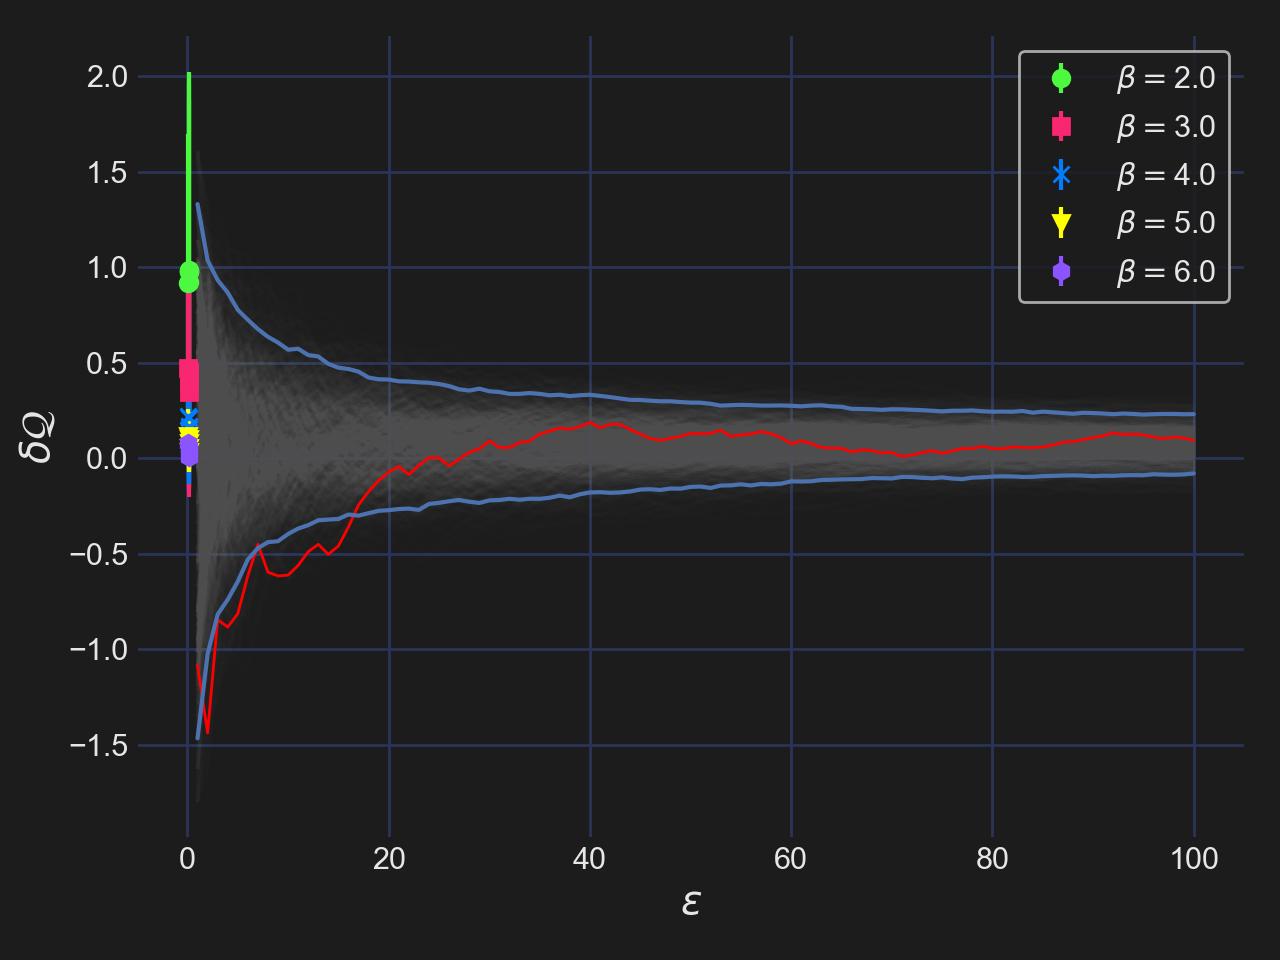

In [146]:
from config import MARKERS

dq_int = {}
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
fig, ax = plt.subplots()
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['std'])
        
    #axes[idx].errorbar(x, y, y_err)
    _ = ax.errorbar(x, y, y_err, ls='', marker=MARKERS[idx], label=r'$\beta = $' + f'{key}')
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\delta\mathcal{Q}$", fontsize='large')
    _ = plt.legend(loc='best')
    #ax.set_title(r"$\beta = $" + f'{key}')
    _ = plt.tight_layout()
        

In [94]:
io.print_dict(dq_int_stats, name='dq_int_stats')
io.print_dict(dq_sin_stats, name='dq_sin_stats')

dq_int_stats:
------------
  4.0:
  ---
    (10, 0.175):
    -----------
      avg: 0.07933614403009415
      std: 0.28694701194763184
      min: 0
      max: 3
    (10, 0.125):
    -----------
      avg: 0.08561745285987854
      std: 0.29094022512435913
      min: 0
      max: 3
    (10, 0.1):
    ---------
      avg: 0.07720345258712769
      std: 0.27463144063949585
      min: 0
      max: 3
    (10, 0.2):
    ---------
      avg: 0.05437120795249939
      std: 0.24383173882961273
      min: 0
      max: 3
    (10, 0.16):
    ----------
      avg: 0.07912912219762802
      std: 0.28512659668922424
      min: 0
      max: 4
    (10, 0.15):
    ----------
      avg: 0.0805392935872078
      std: 0.28575170040130615
      min: 0
      max: 3
  3.0:
  ---
    (10, 0.15):
    ----------
      avg: 0.4561446011066437
      std: 0.6807785034179688
      min: 0
      max: 6
    (10, 0.2):
    ---------
      avg: 0.3745351731777191
      std: 0.6879435777664185
      min: 0
      max: 7
  

In [80]:
%debug

> /Users/saforem2/l2hmc-qcd/l2hmc-qcd/utils/file_io.py(128)print_dict()
    126         sep_str = indent_str + len(name) * '-'
    127         log(sep_str, **kwargs)
--> 128     for key, val in d.items():
    129         if isinstance(d, (AttrDict, dict)):
    130             print_dict(val, indent=indent+2, name=str(key), **kwargs)

ipdb> x = d
ipdb> x.items()
*** AttributeError: 'tuple' object has no attribute 'items'
ipdb> x
(0.079336144, 0.286947)
ipdb> x
(0.079336144, 0.286947)
ipdb> quit


In [77]:
dq_sin_stats

{4.0: {(10, 0.175): (0.1521019, 0.26443395),
  (10, 0.125): (0.20872988, 0.2563737),
  (10, 0.1): (0.220758, 0.24189393),
  (10, 0.2): (0.09623339, 0.23055416),
  (10, 0.16): (0.15968636, 0.26125705),
  (10, 0.15): (0.170749, 0.25906423)},
 3.0: {(10, 0.15): (0.4495216, 0.5215852),
  (10, 0.2): (0.34716162, 0.54797816),
  (10, 0.175): (0.38995403, 0.539692),
  (10, 0.1): (0.47058344, 0.43851098),
  (10, 0.125): (0.4528759, 0.48418865)},
 5.0: {(10, 0.1): (0.11855335, 0.13835438),
  (10, 0.175): (0.05252867, 0.12167294),
  (10, 0.2): (0.032098874, 0.101736665),
  (10, 0.125): (0.10199289, 0.14115505),
  (10, 0.15): (0.08075489, 0.13741735)},
 6.0: {(10, 0.15): (0.04474526, 0.08106277),
  (10, 0.125): (0.057241946, 0.08608513),
  (10, 0.175): (0.022115912, 0.063013814),
  (10, 0.1): (0.07813317, 0.09022369),
  (10, 0.2): (0.008726718, 0.041257907)},
 2.0: {(10, 0.15): (0.9800828, 0.97632915),
  (10, 0.175): (0.9737217, 1.0451647),
  (10, 0.125): (0.986235, 0.88797414),
  (10, 0.1): (0.91

In [66]:
from utils.data_utils import therm_arr

dq_int = {}
for key, val in dq_int_dict.items():
    beta = key
    for k, v in val.items():
        data = therm_arr(v, ret_steps=False)
        try:
            dq_int[key].update({
                k: (np.mean(data), np.std(data))
            })
        except KeyError:
            dq_int[key] = {
                k: (np.mean(data), np.std(data))
            }
    

{4.0: {(10, 0.175): (0.079336144, 0.286947),
  (10, 0.125): (0.08561745, 0.29094023),
  (10, 0.1): (0.07720345, 0.27463144),
  (10, 0.2): (0.054371208, 0.24383174),
  (10, 0.16): (0.07912912, 0.2851266),
  (10, 0.15): (0.08053929, 0.2857517)},
 3.0: {(10, 0.15): (0.4561446, 0.6807785),
  (10, 0.2): (0.37453517, 0.6879436),
  (10, 0.175): (0.4106016, 0.6855541),
  (10, 0.1): (0.4241798, 0.61346316),
  (10, 0.125): (0.43722662, 0.6457952)},
 5.0: {(10, 0.1): (0.011617525, 0.10748271),
  (10, 0.175): (0.008898574, 0.095519304),
  (10, 0.2): (0.0063360166, 0.08042181),
  (10, 0.125): (0.012418249, 0.11172512),
  (10, 0.15): (0.011597873, 0.10837155)},
 6.0: {(10, 0.15): (0.0014181541, 0.038042184),
  (10, 0.125): (0.0018049281, 0.042718466),
  (10, 0.175): (0.00091415126, 0.030859185),
  (10, 0.1): (0.0018011117, 0.042489406),
  (10, 0.2): (0.00043362874, 0.021005195)},
 2.0: {(10, 0.15): (1.3870312, 1.4414281),
  (10, 0.175): (1.3827344, 1.5342593),
  (10, 0.125): (1.3982812, 1.3342794),


In [60]:
k = list(dq_int_dict[2.0].keys())[0]

In [61]:
k

(10, 0.15)

In [63]:
dq_int_dict[2.][k].shape

(5000, 64)

In [44]:
dq_int_dict.keys()

dict_keys([4.0])

In [15]:
hdir = hmc_dirs[0]
run_data_files = sorted(hdir.glob('**/*.z'))

In [17]:
hdirs = [x for x in hdir.iterdir() if x.is_dir()]
hdirs

[PosixPath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043/beta2-2020-10-05-1710')]

In [19]:
zfiles = sorted(hdirs[0].glob('**/*.z'))
zfiles

[]

In [2]:
base_dir = os.path.abspath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/')
hmc_dirs = [
    os.path.join(base_dir, i) for i in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, i))
]

def get_run_data(hmc_dir, fname):
    tmp_dir = os.listdir(hmc_dir)[0]
    run_dir = os.path.join(hmc_dir, tmp_dir) 
    run_data_dir = os.path.j

['/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps0175_bi4_bf4-2020-10-05-131208',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi3_bf3-2020-10-05-125013',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps02_bi3_bf3-2020-10-05-125734',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi5_bf5-2020-10-05-131908',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi3_bf3-2020-10-05-120411',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi4_bf4-2020-10-05-121415',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi6_